# Text Mining- Predicting Airbnb Unlisting

# 2. Initial Treatment

## 2.1. Import Libraries and Global Variables Defintion

In [ ]:
# Utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re
import bz2
import pickle
import _pickle as cPickle
import cupy as cp
import os
import glob
from tqdm import tqdm

from deep_translator import GoogleTranslator
import langcodes
from langdetect import detect
from langdetect import DetectorFactory
from wordcloud import WordCloud

import spacy
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer

# Huggingfaces transformers
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchtext
from torchtext.vocab import GloVe

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler

# Global variables 
sns.set_theme(style="darkgrid")

LEMMATIZER = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words("english"))

spacy.prefer_gpu()
SPACY_NLP = spacy.load('en_core_web_md')

SEED = 42

SENTIMENTAL_PIPELINE = pipeline("sentiment-analysis")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GLOVE = GloVe(name='6B', dim=50)

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 2.2. Auxiliary functions

### 2.2.1. Utilitise

In [3]:
def compressed_pickle(data, title):
    """
    Compress data and save as .pbz2 file.
    """
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [4]:
def decompress_pickle(file):
    """ 
    Decompress .pbz2 file.
    """
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [5]:
def save_model(model, model_name):
    """
    Saves the model as .sav file.
    """
    pickle.dump(model, open('./modelling/' + model_name + '.sav', 'wb'))

In [6]:
def open_model(model_name):
    """
    Opens saved model.
    """
    model = pickle.load(open('./modelling/' + model_name + '.sav', 'rb'))
    return model

### 2.2.2. Data Cleaning

In [7]:
# Translate functions

def row_translator(row, translator):
    '''
    Translate row with strings longer than 5000 characters. Split string into chunks of
    4000 characters and translate each chunk.
    '''
    if len(row) > 5000:
        len_string = 4000
        text_translate = ''
        chunks = [row[i:i+len_string] for i in range(0, len(row), len_string)]
        
        try:  
            for text in chunks:
                text_translate += translator.translate(text) 
        except Exception as error:
            print(error)
            return 'ERROR'  
        return text_translate
    elif (isinstance(row, int)) or (isinstance(row, float)):
        return 'Only Numeric'
    else:
        return str(row)

def translate_max_char_limit_column(df, column, translator):
    '''
    Translate column with strings less than 5000 characters. Split string into chunks of 
    4000 characters and translate each chunk.
    '''
    df_copy = df.copy()
    df_copy[column + '_translate'] = df_copy[column].apply(lambda row: row_translator(row, translator))
    df_copy[column + '_min_5000_char'] = df_copy[column + '_translate']

    return df_copy

def save_df(df_copy, column, last_char):
    '''
    Save translated column as csv file.
    '''

    max_number = str(df_copy.index.max())
    min_number = str(df_copy.index.min())
    
    if column == 'comments':
        df_copy = df_copy.set_index('index')
        df_copy.to_csv(path + 'Project Corpora/' + column + '/train_' + column + '_trans_'+ 
                       min_number + '_' + max_number + '_' + last_char +'.csv')
    else:
        df_copy.to_csv(path + 'Project Corpora/' + column + '/train_' + column + '_trans_'+ 
                       min_number + '_' + max_number + '_' + last_char +'.csv')

def translate_column(df, column, chunk, translator, last_char):
    ''' 
    Translate column, if numeric return 'Only Numeric', if string return string. If string is longer 
    than 5000 characters split string into chunks of 4000 characters and translate each chunk.
    '''
    df_copy = df.copy()
    
    def check_string(row):
        if len(row) > 5000:
            return 'Max limit reached'
        elif row.replace(".", "").replace(",", "").isnumeric():
            return 'Only Numeric'
        else:
            return str(row)
    
    def fix_nan(row, column):
        if isinstance(row[column + '_translate'], float):
            if np.isnan(row[column + '_translate']):
                return row[column]     
        else:
            return row[column + '_translate']

    df_copy[column +'_min_5000_char'] = df_copy[column].apply(lambda row: check_string(row))

    df_copy_max = df_copy[df_copy[column +'_min_5000_char'] == 'Max limit reached'].copy()
    df_copy_orig = df_copy[df_copy[column +'_min_5000_char'] != 'Max limit reached'].copy()
    
    if df_copy_max.shape[0] > 0:
        df_copy_max = translate_max_char_limit_column(df_copy_max, column, translator)

    if df_copy_orig.shape[0] > 0:
        list_values_to_translate = list(df_copy_orig[column + '_min_5000_char'].values)
        list_desc_trans = translator.translate_batch(list_values_to_translate)
        series_desc_trans = pd.Series(list_desc_trans)
        df_copy_orig[column + '_translate'] = series_desc_trans.values
        
    df_copy = pd.concat([df_copy_orig, df_copy_max])
    df_copy[column + '_translate'] = df_copy.apply(lambda row: fix_nan(row, column), axis=1)
    
    save_df(df_copy, column,  last_char)
    
    return

In [8]:
def apply_regex_lowercasing(text):
    """
    Apply regex and lowercasing to a text.
    Removes html tags, line breaks and punctuation except for . , ! ? '
    """
    if isinstance(text, str):
        text = re.sub(r"<.*?>|\_x000D_\n|\n|\_x000D_\r\n", "", text).lower()
        text = re.sub(r"[^a-z\.\,/!/?\']", " ", text)
    else:
        text = ""
    return text

In [9]:
def apply_decontract(df, column):
    """
    Apply decontract to a row of a dataframe.
    """
    df[column] = df[column].apply(lambda x: decontract(x))
    return df

In [10]:
def decontract(text):
    """
    Remove contractions from a text.
    """
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    return text

### 2.2.3. Data Exploration

In [11]:
def plot_hist(df, title, target=None, bins=None):
    """
    Plot a histogram.
    """
    plt.figure(figsize=(6, 4))
    
    if bins is None:
        sns.histplot(x=df, kde=True, stat="count", hue=target)
    else:
        sns.histplot(x=df, kde=True, stat="count", hue=target, bins=bins)
    
    plt.title(title, fontsize=14)
    plt.show()

In [12]:
def plot_bar(data, title):
    """
    Plot a bar chart.
    """
    plt.figure(figsize=(6, 4))
    sns.barplot(x=data.index, y=data.values)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=90)
    plt.show()

In [13]:
def word_count(text):
    """
    Count the number of words in a text, excluding punctuation.
    """
    list_tokens = [word for word in text if word.isalpha()]
    return len(list_tokens)

In [14]:
def character_count(text):
    """
    Count the number of characters in a text, excluding punctuation.
    """
    list_tokens = [word for word in text if word.isalpha()]
    total_characters = 0
    for string in list_tokens:
        total_characters += len(string)
    return total_characters

In [15]:
def extract_stopwords(dataset, language="english"):
    """ 
    Extract stopwords from a dataset and return a dataframe with the stopwords.
    """

    stop_words = set(stopwords.words(language))

    stop_words_list = []
    
    for row in dataset:
        stop_words_in_row = [token for token in row if token in stop_words]
        stop_words_list.append(stop_words_in_row)

    stop_word_list_flatten = [item for sublist in stop_words_list for item in sublist]
    stop_word_df = pd.DataFrame(stop_word_list_flatten, columns=["stopwords"])
    
    return stop_word_df

In [16]:
def generate_wordcloud(df, title="Wordcloud", stopwords_language="english", path=None):
    """
    Generate a wordcloud from a text.
    """
    if isinstance(df.iloc[0][0], tuple):
        # print("Tuple detected")
        text = " ".join([token[0] for row in df for token in row])
    else:
        text = " ".join([token for row in df for token in row])
    # Create a frequency distribution of the remaining words

    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=set(stopwords.words(stopwords_language)), 
                          background_color="white").generate_from_text(text)

    wordcloud.to_file(path + title + '.jpeg')

In [17]:
def plot_freq_dist(df, title):
    """
    Plot the frequency distribution of a text.
    """
    # create out of column of df one string from all tokens
    text = [token for list in df for token in list]
    plt.figure(figsize=(6, 4))
    fdist = FreqDist(text)
    plt.title(title, fontsize=14)
    fdist.plot(30, cumulative=False)

### 2.2.4. Data Pre-Processing

In [18]:
def transform_string_to_list(df):
    """
    Transform a string to a list.
    """
    if isinstance(df.iloc[0], str):
        df = df.apply(ast.literal_eval)
    else:
        print(f"Column is not a string.")
        print(f"Data type of column is {type(df[0])}.")
    return df

In [19]:
def remove_stopwords(df, column, stop_words):
    """
    Remove stopwords from a text.
    """
    df[column] = df[column].apply(lambda x: [token for token in x if token not in stop_words])

    return df

In [20]:
def apply_spacy_pipe(row):
    """
    Apply spacy pipeline to a text to extract:
    - Lemmatization
    - Part of speech tagging
    - Named entity recognition
    - Word vectors

    Parameters
    ----------
    row : str

    Returns
    -------
    pd.Series : lemma_list, pos_list, ner_label_list, tok2vec_list
        Series of lists with the extracted features.
    """
    lemma_list, pos_list, ner_label_list, tok2vec_list = [[] for _ in range(4)]
    for doc in SPACY_NLP(row):
        lemma_list.append(doc.lemma_)
        pos_list.append(doc.pos_)
        ner_label_list.append([doc.ent_type_, doc.ent_iob_])
        tok2vec_list.append(doc.vector)
    return  pd.Series([lemma_list, pos_list, ner_label_list, tok2vec_list])

In [21]:
def spacy_pipe(df, columns, column_names):
    """
    Lemmatize and add POS tags to each row of a dataframe.
    """
    df[column_names] = df[columns].str.join(" ").apply(lambda row: apply_spacy_pipe(row))
    return df

In [22]:
def replace_ner(tokens, ner):
    """
    Replace tokens with named entities.
    """
    for index, ner_tag in enumerate(ner):
        if ner_tag[0] != "":
            tokens[index] = ner_tag[0].lower()
    return tokens

In [23]:
def replace_punctuation(tokens, pos):
    """
    Replace punctuation with "punct" tag.
    """
    for index, pos_tag in enumerate(pos):
        if pos_tag == "PUNCT":
            tokens[index] = "punct"
    return tokens

In [24]:
def mean_vector(row):
    """
    Function to calculate the mean vector of a row of word2vec vectors.
    Cupy ndarray was used from Spacy to speed up the calculation, therefore the conversion to numpy.
    """
    array_list = []
    for tok_array in row:
        tok_array = cp.asnumpy(tok_array)
        array_list.append(np.mean(tok_array))
    return np.mean(array_list)

In [25]:
def remove_nans(data, target):
    """
    Remove rows with NaNs from a dataframe.
    """
    target.drop(data[data.isna().any(axis=1)].index, inplace=True)
    data.dropna(inplace=True)

### 2.2.5. Feature Engineering

In [26]:
def fit_train_tfidf(df, columns):
    """
    Fit a tfidf model.
    """
    df['combined_desc_host'] = df[columns[0]].str.join(' ') + ' ' + df[columns[1]].str.join(' ')
    model = TfidfVectorizer()
    model = model.fit(df['combined_desc_host'])
    return model

In [27]:
def create_tfidf_dataframe(df, columns, model):
    """
    Create a dataframe with tfidf vectors.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with the text columns.
    columns : list
        List of columns with the text.
    model : sklearn.feature_extraction.text.TfidfVectorizer
        Fitted tfidf model.

    Returns
    -------
    df_tfidf : pd.DataFrame
        Dataframe with the tfidf vectors.
    """
    
    df['combined_desc_host'] = df[columns[0]].str.join(' ') + ' ' + df[columns[1]].str.join(' ')
    X = model.transform(df['combined_desc_host'])
    tfidf_column_names = model.get_feature_names_out()
    df_tfidf = pd.DataFrame(X.toarray(), columns=tfidf_column_names, index=df.index)
    return df_tfidf

In [28]:
def word2vec(row):
    """
    Apply word2vec to a row with Spacy.
    """
    tok2vec_list = []
    for doc in SPACY_NLP(row):
        tok2vec_list.append(doc.vector)
    return  tok2vec_list

In [29]:
def word2vec_pipe(df, column_list, column_tok2vec_list):
    """
    Apply word2vec to a dataframe with Spacy.
    Returns a dataframe with the average of all tokens of the row.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with the text.
    column_list : list
        List of columns with the text.
    column_tok2vec_list : list
        List of columns with the word2vec vectors.

    Returns
    -------
    df[column_tok2vec_list] : pd.DataFrame
        Dataframe with the word2vec vectors.    
    """
    
    for column, column_tok2vec in zip(column_list, column_tok2vec_list):
        df[column_tok2vec] = df[column].str.join(" ").apply(lambda row: word2vec(row))
    print("Word2Vec creation done.")

    for column_tok2vec in column_tok2vec_list:
        df[column_tok2vec] = df[column_tok2vec].apply(lambda x: mean_vector(x))
        
    return df[column_tok2vec_list]

In [30]:
def sentimetal_analysis(df, column, sentiment_pipeline):
    """
    Create a dataframe with the sentiment analysis of a text.
    """
    df_copy = df.copy()
    df_copy[column] = df_copy[column].fillna(" ")
    df_copy[column + '_reduce_512'] = df_copy['comments_translate'].str[:512]

    list_values = list(df_copy[column + '_reduce_512'].values)
    list_index = list(df_copy[column + '_reduce_512'].index)
    list_labels_scores = sentiment_pipeline(list_values)

    df_sentiment = pd.DataFrame(list_labels_scores, index=list_index)
    df_final = df_copy.join(df_sentiment)
    # max_number = str(df_final.index.max())
    # min_number = str(df_final.index.min())
    df_final = df_final.drop(columns=['comments_translate_reduce_512'])
    # df_final.to_csv(path + '/Project Corpora/sentiment/data_'+ min_number + '_' + max_number +'.csv')
    return df_final

In [31]:
def get_word_vectors(tokens):
    """
    Get the GloVe word vectors of a list of tokens.
    """
    return [GLOVE[word] for word in tokens]

In [32]:
def create_glove(df, column_list):
    """
    Create GloVe vectors for a dataframe.
    """
    df = df.copy()
    for column in column_list:
        df["glove_" + column] = df[column].apply(lambda x: get_word_vectors(x))
    return df[[column for column in df.columns if "glove_" in column]]

### 2.2.6. Modeling

In [33]:
def clean_dataset(dataset, train_flag):
    """
    Applies all the cleaning steps to the dataset.
    Train_flag is True if the dataset is the training set, False if it is the test set.
    """
    # Add translated columns
    if train_flag:
        dataset_translated = (
        pd.read_csv("Project Corpora/0.trans/train/train_translated.csv")
        [["index", "description_translate", "host_about_translate"]]
        )
    else:
        dataset_translated = (
        pd.read_csv("Project Corpora/0.trans/test/test_translated.csv")
        [["index", "description_translate", "host_about_translate"]]
        )

    dataset_translated.set_index("index", inplace=True)
    dataset_translated.index.name = "flat_index"

    dataset = pd.merge(dataset, dataset_translated, on="flat_index", how="inner")

    # Regular expressions and lowercasing
    for column in ["description_translate", "host_about_translate"]:
        dataset[column] = dataset[column].apply(apply_regex_lowercasing)

    # Contractions
    dataset = apply_decontract(dataset, "description_translate")
    dataset = apply_decontract(dataset, "host_about_translate")

    # Tokenization
    for column in ["description_translate", "host_about_translate"]:
        dataset[column + "_tokens"] = dataset[column].apply(word_tokenize)
    print("Cleaned dataset.")

    return dataset

In [34]:
def preprocess_dataset(dataset):
    """
    Applies all the preprocessing steps to the dataset.

    Parameters
    ----------
    dataset : pd.DataFrame
        Input dataset.

    Returns
    -------
    dataset_lemma : pd.DataFrame
        Dataset lemmatized, POS and NER treated.
    dataset_tok2vec : pd.DataFrame
        Dataset with word2vec vectors.
    """
    
    # Remove stopwords
    dataset = remove_stopwords(dataset, "description_translate_tokens", STOP_WORDS)
    dataset = remove_stopwords(dataset, "host_about_translate_tokens", STOP_WORDS)

    # Spacy pipeline
    dataset = spacy_pipe(dataset,
                          "description_translate_tokens",
                          ["description_lemmas", "description_pos", "description_ner", "description_tok2vec"])
    
    dataset = spacy_pipe(dataset,
                          "host_about_translate_tokens",
                          ["host_about_lemmas", "host_about_pos", "host_about_ner", "host_about_tok2vec"])
    
    # Split dataset for Lemmatization, POS and NER
    column_list = ["description_lemmas",  "description_pos", "description_ner", 
               "host_about_lemmas", "host_about_pos", "host_about_ner"]
    dataset_lemma = dataset[column_list].copy()
    dataset_lemma.rename(columns={"description_lemmas": "description_tokens",
                                  "host_about_lemmas": "host_about_tokens"}, inplace=True)
    # Treat POS and NER
    for column in ["description", "host_about"]:
        dataset_lemma[column + "_tokens"] = dataset_lemma.apply(
        lambda x: replace_ner(x[column + "_tokens"], x[column + "_ner"]), axis=1)

    for column in ["description", "host_about"]:
        dataset_lemma[column + "_tokens"] = dataset_lemma.apply(
        lambda x: replace_punctuation(x[column + "_tokens"], x[column + "_pos"]), axis=1)

    # Word2Vec
    word2vec_columns = ["description_tok2vec", "host_about_tok2vec"]
    dataset_word2vec = dataset[word2vec_columns].copy()

    for column in word2vec_columns:
        dataset_word2vec[column] = dataset_word2vec[column]\
                                        .apply(lambda x: mean_vector(x))
    print("Created datasets.")
        
    return dataset_lemma, dataset_word2vec

In [35]:
def train_classifier(classifier, X_train, y_train, X_val, y_val, X_test, y_test, save_model_name):
    """
    Train a sklearn classifier and save it.

    Parameters
    ----------
    classifier : sklearn classifier
        Classifier to train.
    X_train : pandas.DataFrame
        Training data.
    y_train : pandas.Series
        Training labels.
    X_val : pandas.DataFrame
        Validation data.
    y_val : pandas.Series
        Validation labels.
    X_test : pandas.DataFrame
        Test data.
    y_test : pandas.Series
        Test labels.
    save_model_name : str
        Name of the file to save the model.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe with the results of the model.
    classifier : sklearn classifier
        Trained model.
    """
    classifier.fit(X_train, y_train)
    save_model(classifier, save_model_name)
    
    y_pred_train = classifier.predict(X_train)
    cla_report_train = classification_report(y_train, y_pred_train, output_dict=True)

    y_pred_val = classifier.predict(X_val)
    cla_report_val = classification_report(y_val, y_pred_val, output_dict=True)

    y_pred_test = classifier.predict(X_test)
    cla_report_test = classification_report(y_test, y_pred_test, output_dict=True)

    df_train = pd.DataFrame(cla_report_train)
    df_val = pd.DataFrame(cla_report_val)
    df_test = pd.DataFrame(cla_report_test)

    df = pd.concat([df_train, df_val, df_test], axis=1, keys=['train', 'val', 'test']).transpose().applymap(lambda x: round(x, 3))
    
    return df, classifier

In [36]:
def tfidf_pca_pipe(df, tfidf_model, pca_model, n_components):
    """
    Apply TF-IDF and PCA to a dataframe.
    Returns a dataframe with the PCA components.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with the text.
    tfidf_model : sklearn.model
        TF-IDF model.
    pca_model : sklearn.model
        PCA model.

    Returns
    -------
    df : pd.DataFrame
        Dataframe with the PCA components.
    """
    df = create_tfidf_dataframe(df, ['description_tokens', 'host_about_tokens'], tfidf_model)
    df = pca_model.transform(df)
    df = pd.DataFrame(df, columns=[f'PC{i+1}' for i in range(n_components)])
    return df

In [37]:
def create_vectors(dataset, tfidf_model, pca_model, pca_components):
    """
    Create the different vectors for the dataset.
    """
    data_preprocessed, _ = preprocess_dataset(clean_dataset(dataset, train_flag=True))

    data_word2vec = word2vec_pipe(data_preprocessed.copy(),
                                ["description_tokens","host_about_tokens"],
                                ["description_tok2vec", "host_about_tok2vec"])

    data_tfidf_pca = tfidf_pca_pipe(data_preprocessed.copy(), tfidf_model, pca_model, pca_components)

    data_glove = create_glove(data_preprocessed, ["description_tokens", "host_about_tokens"])

    return data_preprocessed, data_word2vec, data_tfidf_pca, data_glove

In [38]:
def join_reviews(flat, sentimental_reviews):
    """
    Join flat and sentimental_reviews dataframes on flat_index column.
    Fill NaN values with 0, because some flats don't have reviews.
    """
    df_flat = flat.copy()
    df_reviews = sentimental_reviews.copy()
    # join on index
    df_flat = df_flat.merge(df_reviews, how='left', left_index=True, right_index=True)
    df_flat = df_flat.fillna(0)
    return df_flat

In [39]:
def transform_glovo_column_to_model(df, column):
    '''
    Transform column with glove vectors to tensor

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with columns description_glove_vec, host_about_glove_vec, NEGATIVE, POSITIVE
    column : string
        Column name to be transformed

    Returns
    -------
    torch_col : torch tensor
        Tensor with glove vectors
    '''
    def stack_tensor(row):
        if len(row)>0:
            return torch.stack(row)
        return torch.zeros(1, 50)

    def pad_tensor(tensor, max_length):
        pad_size = max_length - tensor.size(0)
        return torch.cat((tensor, torch.zeros(pad_size, tensor.size(1))), dim=0)

    stack_tensors = df[column].apply(lambda row: stack_tensor(row))

    max_length = stack_tensors.apply(lambda row: len(row)).max()
    tensor_col = torch.stack(stack_tensors.apply(lambda row: pad_tensor(row, max_length)).to_list())
    return tensor_col

In [40]:
def create_tensor(X, y):
    '''
    Create tensor dataset

    Parameters
    ----------
    X : pandas dataframe
        Dataframe with columns description_glove_vec, host_about_glove_vec, NEGATIVE, POSITIVE
    y : pandas series
        Series with target values

    Returns
    -------
    col_desc_tensor : torch tensor
        Tensor with description glove vectors
    col_host_tensor : torch tensor
        Tensor with host about glove vectors
    col_neg_tensor : torch tensor
        Tensor with NEGATIVE values
    col_pos_tensor : torch tensor
        Tensor with POSITIVE values
    y_tensor : torch tensor
        Tensor with target values
    '''

    col_desc_tensor = transform_glovo_column_to_model(X, 'description_glove_vec')
    col_host_tensor = transform_glovo_column_to_model(X, 'host_about_glove_vec')

    tensor_size = list(col_desc_tensor.size())

    col_neg_tensor = torch.tensor(X['NEGATIVE'].values, dtype=torch.float).unsqueeze(1).unsqueeze(1).expand((tensor_size[0], 1, tensor_size[-1]))
    col_pos_tensor = torch.tensor(X['POSITIVE'].values, dtype=torch.float).unsqueeze(1).unsqueeze(1).expand((tensor_size[0], 1, tensor_size[-1]))

    y_tensor = torch.tensor(y.values, dtype=torch.long)#.unsqueeze(1)

    return col_desc_tensor, col_host_tensor, col_neg_tensor, col_pos_tensor, y_tensor

In [41]:
def create_dataloader(train_df, val_df, test_df, column_list, max_len, batch_size, tokenizer):
    """
    Creates the torch dataloaders for the train, validation and test sets.

    Parameters
    ----------
    train_df : pd.DataFrame
        Train dataframe.
    val_df : pd.DataFrame
        Validation dataframe.
    test_df : pd.DataFrame
        Test dataframe.
    column_list : list
        List of columns to be used.
    max_len : int
        Maximum length of the text.
    batch_size : int
        Batch size.
    tokenizer : transformers.tokenizer
        Tokenizer.

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
        Train dataloader.
    val_loader : torch.utils.data.DataLoader
        Validation dataloader.
    test_loader : torch.utils.data.DataLoader
        Test dataloader.
    """
    train_dataset = TextDataset(train_df[column_list],
                            tokenizer,
                            max_len,
                            column_list=column_list[:-1],
                            target_column="unlisted")

    val_dataset = TextDataset(val_df[column_list],
                          tokenizer,
                          max_len,
                          column_list=column_list[:-1],
                          target_column="unlisted")

    test_dataset = TextDataset(test_df[column_list],
                            tokenizer,
                            max_len,
                            column_list=column_list[:-1],
                            target_column="unlisted")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [42]:
def train_epoch(model, model_name, data_loader, optimizer, criterion, scheduler):
    """
    Trains the model for one epoch on the data loader.

    Parameters
    ----------
    model : torch.model
        Model to train.
    data_loader : torch.data.DataLoader
        Data loader from torch library.
    optimizer : torch.optim
        Optimizer from torch library.
    device : torch.device
        Device to use.
    criterion : torch.nn
        Loss function from torch library.

    Returns
    -------
    loss_value : float
        Loss value. 
    precision : float
        Precision value.
    recall : float
        Recall value.
    f1 : float
        F1 score.
    accuracy : float
        Accuracy score. 
    """
    model.train()
    y_true = torch.tensor([]).to(DEVICE)
    y_pred = torch.tensor([]).to(DEVICE)
    running_loss = 0.0
    dropout = torch.nn.Dropout(0.2)
    for batch in data_loader:
        if model_name == 'transformer':
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            outputs = outputs.logits
            outputs = dropout(outputs) 
        else:
            outputs = model(batch[0].to(DEVICE),
                            batch[1].to(DEVICE),
                            batch[2].to(DEVICE),
                            batch[3].to(DEVICE))
            labels = batch[4].to(DEVICE)

        loss = criterion(outputs, labels)
        outputs = nn.Softmax(dim=1)(outputs)

        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        y_true = torch.cat((y_true, labels), dim=0)
        y_pred = torch.cat((y_pred, torch.argmax(outputs, dim=1)), dim=0)

    y_true = y_true.to("cpu").detach().numpy()
    y_pred = y_pred.to("cpu").detach().numpy()
    loss_value = running_loss / len(data_loader)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)
    return loss_value, precision, recall, f1, accuracy

In [43]:
def eval_model(model, model_name, data_loader, criterion):
    """
    Evaluates the model for one epoch on the data loader.

    Parameters
    ----------
    model : torch.model
        Model to train.
    data_loader : torch.data.DataLoader
        Data loader from torch library.
    optimizer : torch.optim
        Optimizer from torch library.
    criterion : torch.nn
        Loss function from torch library.

    Returns
    -------
    loss_value : float
        Loss value. 
    precision : float
        Precision value.
    recall : float
        Recall value.
    f1 : float
        F1 score.
    accuracy : float
        Accuracy score. 
    """
    model.eval()
    y_true = torch.tensor([]).to(DEVICE)
    y_pred = torch.tensor([]).to(DEVICE)
    running_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:

            if model_name == 'transformer':
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['label'].to(DEVICE)

                outputs = model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                labels=labels)
                outputs = outputs.logits
            else:
                outputs = model(batch[0].to(DEVICE),
                                batch[1].to(DEVICE),
                                batch[2].to(DEVICE),
                                batch[3].to(DEVICE))
                labels = batch[4].to(DEVICE)

            loss = criterion(outputs, labels)
            outputs = nn.Softmax(dim=1)(outputs)

            running_loss += loss.item()
            y_true = torch.cat((y_true, labels), dim=0)
            y_pred = torch.cat((y_pred, torch.argmax(outputs, dim=1)), dim=0)

    y_true = y_true.to("cpu").detach().numpy()
    y_pred = y_pred.to("cpu").detach().numpy()
    loss_value = running_loss / len(data_loader)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)
    return loss_value, precision, recall, f1, accuracy

In [44]:
def run_model(model, model_name, train_loader, val_loader, test_loader, learning_rate=1e-4, epochs=5):
    """
    Trains and evaluates the model for the given number of epochs.

    Parameters
    ----------
    model : torch.model
        Model to train.
    train_loader : torch.data.DataLoader
        Train data loader.
    val_loader : torch.data.DataLoader
        Validation data loader.
    test_loader : torch.data.DataLoader
        Test data loader.
    learning_rate : float, optional
        Learning rate. The default is 1e-4.
    epochs : int, optional
        Number of epochs. The default is 5.

    Returns
    -------
    test_precision : float
        Test precision score.
    test_recall : float
        Test recall score.
    test_f1_score : float
        Test F1 score.
    test_accuracy : float
        Test accuracy score.
    model : torch.model
        Trained model.
    """
    torch.cuda.empty_cache()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print('-' * 10)

        # Train block.
        train_loss, train_precision, train_recall, train_f1_score, train_accuracy = train_epoch(model, model_name, train_loader, optimizer, criterion, scheduler)
        train_loss = np.round(train_loss, 3)
        train_precision = np.round(train_precision, 3)
        train_recall = np.round(train_recall, 3)
        train_f1_score = np.round(train_f1_score, 3)
        train_accuracy = np.round(train_accuracy, 3)
        print(f'Train -> Loss: {train_loss}, Precision: {train_precision}, ' \
              f'Recall: {train_recall}, F1_score: {train_f1_score}, Accuracy: {train_accuracy}')

        # Validation block.
        val_loss, val_precision, val_recall, val_f1_score, val_accuracy = eval_model(model, model_name, val_loader, criterion)
        val_loss = np.round(val_loss, 3)
        val_precision = np.round(val_precision, 3)
        val_recall = np.round(val_recall, 3)
        val_f1_score = np.round(val_f1_score, 3)
        val_accuracy = np.round(val_accuracy, 3)
        print(f'Val -> Loss: {val_loss}, Precision: {val_precision}, ' \
        f'Recall: {val_recall}, F1_score: {val_f1_score}, Accuracy: {val_accuracy}')
        print("\n")

    # Test block.
    test_loss, test_precision, test_recall, test_f1_score, test_accuracy = eval_model(model, model_name, test_loader, criterion)
    test_loss = np.round(test_loss, 3)
    test_precision = np.round(test_precision, 3)
    test_recall = np.round(test_recall, 3)
    test_f1_score = np.round(test_f1_score, 3)
    test_accuracy = np.round(test_accuracy, 3)
    print(f'Test -> Loss: {test_loss}, Precision: {test_precision}, ' \
        f'Recall: {test_recall}, F1_score: {test_f1_score}, Accuracy: {test_accuracy}')

    return test_precision, test_recall, test_f1_score, test_accuracy, model

In [45]:
def change_sentiment_string(df, column_list):
    """
    Change the sentiment review count to a string, which will be used as input for the transformer model.
    """
    for column in column_list:
        df[column] = df[column].apply(lambda row: f"I have {int(row)} {column.lower()} reviews.")
    return df

In [46]:
def join_tokens_to_string(df, column_list):
    """
    Joins the tokens to a string.
    """
    for column in column_list:
        df[column] = df[column].apply(lambda row: " ".join(row))
    return df

### 2.2.7. Model Classes

In [47]:
class TextDataset(Dataset):
    """
    Custom Dataset for loading BERT embeddings.
    """
    def __init__(self, dataframe, tokenizer, max_len, column_list, target_column):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.column_list = column_list
        self.target_column = target_column

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        texts = [row[column] for column in self.column_list]
        texts = ' '.join(texts)
        label = row[self.target_column]
        encodings = self.tokenizer(
            texts,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long),
        }

In [48]:
class LSTM(nn.Module):
    """
    LSTM architecture.
    """
    def __init__(self):
        super().__init__()
        self.lstm_desc = nn.LSTM(50, 50, batch_first=True)
        self.lstm_host = nn.LSTM(50, 50, batch_first=True)
        self.dense_concat = nn.Linear(200, 64)
        self.relu = nn.ReLU()
        self.dense_output = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, desc_input, host_input, negative_input, positive_input):
        x_desc, _ = self.lstm_desc(desc_input)
        x_host, _ = self.lstm_host(host_input)
        x_desc = x_desc[:, -1, :]
        x_host = x_host[:, -1, :]
        negative_input = negative_input.squeeze(dim=1)
        positive_input = positive_input.squeeze(dim=1)
        concatenated = torch.cat([x_desc, x_host, negative_input, positive_input], dim=-1)
        x = self.dense_concat(concatenated)
        x = self.relu(x)
        x = self.dense_output(x)

        return x

In [ ]:
class GRU_RNN(nn.Module):
    """
    GRU_RNN architecture.
    """
    def __init__(self, seed=None):
        super().__init__()
        self.rnn_desc = nn.GRU(50, 50, batch_first=True)
        self.rnn_host = nn.GRU(50, 50, batch_first=True)
        self.dense_concat = nn.Linear(200, 64)
        self.relu = nn.ReLU()
        self.dense_output = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, desc_input, host_input, negative_input, positive_input):
        x_desc, _ = self.rnn_desc(desc_input)
        x_host, _ = self.rnn_host(host_input)
        x_desc = x_desc[:, -1, :]
        x_host = x_host[:, -1, :]
        negative_input = negative_input.squeeze(dim=1)
        positive_input = positive_input.squeeze(dim=1)
        concatenated = torch.cat([x_desc, x_host, negative_input, positive_input], dim=-1)
        x = self.dense_concat(concatenated)
        x = self.relu(x)
        x = self.dense_output(x)

        return x

## 2.3. Extract data

In the following project the train.csv and test.csv data will be called train_flat and test_flat.

In [50]:
train_ds_reviews = pd.read_excel("Project Corpora/1.raw/train_reviews.xlsx")
train_ds_reviews.rename(columns={"index": "flat_index"}, inplace=True)
train_ds_reviews.head()

,flat_index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [51]:
train_ds_flat = pd.read_excel("Project Corpora/1.raw/train.xlsx", index_col="index")
train_ds_flat.index.name = "flat_index"
train_ds_flat.head()

,description,host_about,unlisted
flat_index,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [52]:
test_ds_reviews = pd.read_excel("Project Corpora/1.raw/test_reviews.xlsx")
test_ds_reviews.rename(columns={"index": "flat_index"}, inplace=True)
test_ds_reviews.head()

,flat_index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


In [53]:
test_ds_flat = pd.read_excel("Project Corpora/1.raw/test.xlsx", index_col="index")
test_ds_flat.index.name = "flat_index"
test_ds_flat.head()

,description,host_about
flat_index,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
4,Charming Apartment Close to the Bay of Cascais...,:)
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


## 2.4. Split dataset

We partition the training dataset into three subsets, the training set, validation set, and test set. Despite being given a test set, we decide to conduct an additional test on this set as a means of validating our final model.

In [54]:
target = train_ds_flat["unlisted"]
dataset = train_ds_flat.drop(columns=["unlisted"])

X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(dataset, 
                                                                        target, 
                                                                        test_size=0.1, 
                                                                        random_state=42, 
                                                                        stratify=target)

X_train_flat, X_val_flat, y_train_flat, y_val_flat = train_test_split(X_train_flat, 
                                                                      y_train_flat, 
                                                                      test_size=0.1, 
                                                                      random_state=42, 
                                                                      stratify=y_train_flat)
print(f"Split successful!")
print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_val_flat shape: {X_val_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

Split successful!
X_train_flat shape: (10121, 2)
X_val_flat shape: (1125, 2)
X_test_flat shape: (1250, 2)


# 3. Data Exploration

## 3.1. Data Cleaning

Before the general exploration of the dataset, different treatments will be applied on the train
dataset to simplfy the anaylsis and future steps.
1. Translation of the corpus to the English language
2. Noise removal with regular expressions of HTML tags, line breaks and numbers
3. Lowercasing of the text
4. Treatment of contractions
5. Tokenization of the text

Translating the corpus into English enables easier comparison and alignment of data for better understanding the whole corpora and for future model training.  Additionally, a sentiment analysis is done during the feature engineering phase, which is easier to compute with one single language.

### 3.1.1. Translation to English

The complete translation of the training corpora was done with help of the Google Translate API. Due to the expensive computational task, the translation work was ran outside the notebook by a Python script in chunks, finnaly two CSV were generated with the translated columns.


In [56]:
# Code is commented, because translation will take a long time to run.
# translator = GoogleTranslator(source='auto', target='en')
# translate_column(dataset, 'comments', 0, translator, 'translated')

# translate_column(dataset, 'description', 0, translator, 'translated')

# translate_column(train_ds_reviews, 'comments', 0, translator, 'translated')

In [57]:
train_ds_flat_translated = (
    pd.read_csv("Project Corpora/0.trans/train/train_translated.csv")
    [["index", "description_translate", "host_about_translate"]]
    )

train_ds_flat_translated.set_index("index", inplace=True)
train_ds_flat_translated.index.name = "flat_index"

X_train_flat = pd.merge(X_train_flat, train_ds_flat_translated, on="flat_index", how="inner")

X_train_flat.head(2)

,description,host_about,description_translate,host_about_translate
flat_index,,,,
1479,If you want to spend a couple of days or a lon...,"We are the couple J&J who like to receive ""fri...",If you want to spend a couple of days or a lon...,"We are the couple J&J who like to receive ""fri..."
3655,This outstanding property in charming Cascais ...,"Long Airbnb partner, hosted over 400 guests ov...",This outstanding property in charming Cascais ...,"Long Airbnb partner, hosted over 400 guests ov..."


In [58]:
train_ds_reviews = pd.read_csv("Project Corpora/0.trans/train/train_reviews_translated.csv")

train_ds_reviews.rename(columns={"index": "flat_index"}, inplace=True)
train_ds_reviews.drop(columns=["Unnamed: 0"], inplace=True)

train_ds_reviews.head(2)

,flat_index,comments,comments_min_5000_char,comments_translate
0,1,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...
1,1,good<br/>,good<br/>,good<br/>


### 3.1.2. Regular Expressions and Lowercasing

Noise removal with regular expressions of HTML tags, line breaks and numbers and lowercasing of the text.

In [59]:
for column in ["description_translate", "host_about_translate"]:
    X_train_flat[column] = X_train_flat[column].apply(apply_regex_lowercasing)

X_train_flat.head(2)

,description,host_about,description_translate,host_about_translate
flat_index,,,,
1479,If you want to spend a couple of days or a lon...,"We are the couple J&J who like to receive ""fri...",if you want to spend a couple of days or a lon...,we are the couple j j who like to receive fri...
3655,This outstanding property in charming Cascais ...,"Long Airbnb partner, hosted over 400 guests ov...",this outstanding property in charming cascais ...,"long airbnb partner, hosted over guests ov..."


In [60]:
train_ds_reviews["comments_translate"] = train_ds_reviews["comments_translate"].apply(apply_regex_lowercasing)

train_ds_reviews.head(2)

,flat_index,comments,comments_min_5000_char,comments_translate
0,1,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...
1,1,good<br/>,good<br/>,good


### 3.1.3. Treat contractions

Contractions are shortened forms of words or phrases created by combining two words together and replacing one or more letters with an apostrophe ('), which represents the omitted letters.
We decide to treat the contractions in the corpora, to improve the tokenization of contracted words. For that we apply regular expressions, to replace the missing letters.
Several methods for treating contractions were tested but the only satisfying solution represents the replacement of replacing the apostrophe with the missing letters.
Contractions like she'll could mean she shall or she will, but we had to decide for one approach, that is why we defined the following rules:

| contraction|full word|
| -- |-- |
n\'t| not|
're| are|
's | is|
'd | would|
'll | will|
't | not|
've | have|
'm | am|

In [61]:
X_train_flat = apply_decontract(X_train_flat, "description_translate")

X_train_flat = apply_decontract(X_train_flat, "host_about_translate")

train_ds_reviews = apply_decontract(train_ds_reviews, "comments_translate")

### 3.1.4. Tokenization

Tokenize the columns with Word Tokenizer from NLTK library. A TreebankWordTokenizer and PunktSentenceTokenizer are applied.
These tokenizers incorporate a variety of common rules for English like contractions and treats punctuation as single tokens.

In [62]:
for column in ["description_translate", "host_about_translate"]:
    X_train_flat[column + "_tokens"] = X_train_flat[column].apply(word_tokenize)

X_train_flat.head(2)

,description,host_about,description_translate,host_about_translate,description_translate_tokens,host_about_translate_tokens
flat_index,,,,,,
1479,If you want to spend a couple of days or a lon...,"We are the couple J&J who like to receive ""fri...",if you want to spend a couple of days or a lon...,we are the couple j j who like to receive fri...,"[if, you, want, to, spend, a, couple, of, days...","[we, are, the, couple, j, j, who, like, to, re..."
3655,This outstanding property in charming Cascais ...,"Long Airbnb partner, hosted over 400 guests ov...",this outstanding property in charming cascais ...,"long airbnb partner, hosted over guests ov...","[this, outstanding, property, in, charming, ca...","[long, airbnb, partner, ,, hosted, over, guest..."


In [63]:
train_ds_reviews["comments_translate_tokens"] = (train_ds_reviews["comments_translate"]
                                                 .apply(lambda x: word_tokenize(x)))

train_ds_reviews.head(2)

,flat_index,comments,comments_min_5000_char,comments_translate,comments_translate_tokens
0,1,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...,"[this, is, a, very, cozy, and, comfortable, ho..."
1,1,good<br/>,good<br/>,good,[good]


## 3.2. General Analysis

The general analysis is done separately for the dependent variable and independet variables.  
For the independent variables of the `X_train_flat` and ``train_ds_reviews`` datasets we apply several techniques:

- Word and character count
- Stopwords
- Wordcloud and Word Frequency

In [65]:
# Create a copy of X_train_flat for further exploration.
X_train_flat_explo = X_train_flat.copy()

# Create a copy of X_train_flat for further exploration.
train_ds_reviews_explo = train_ds_reviews.copy()

### 3.2.1. Dependent variable

In [66]:
y_train_flat.info()

<class 'pandas.core.series.Series'>
Index: 10121 entries, 1479 to 11399
Series name: unlisted
Non-Null Count  Dtype
--------------  -----
10121 non-null  int64
dtypes: int64(1)
memory usage: 158.1 KB


In [67]:
y_train_flat.describe()

count    10121.000000
mean         0.277147
std          0.447612
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: unlisted, dtype: float64

In [68]:
y_train_flat.unique()

array([0, 1], dtype=int64)

In [69]:
number_of_unlisted_flats = len(y_train_flat[y_train_flat == 0])
number_of_listed_flats = len(y_train_flat[y_train_flat == 1])
total_number_of_flats = len(y_train_flat)

print(f"Number of listed flats: {number_of_unlisted_flats} \
({number_of_unlisted_flats / total_number_of_flats * 100:.2f}% of all flats)"
)
print(f"Number of unlisted flats: {number_of_listed_flats} \
({(number_of_listed_flats) / total_number_of_flats * 100:.2f}% of all flats)"
)

Number of listed flats: 7316 (72.29% of all flats)
Number of unlisted flats: 2805 (27.71% of all flats)


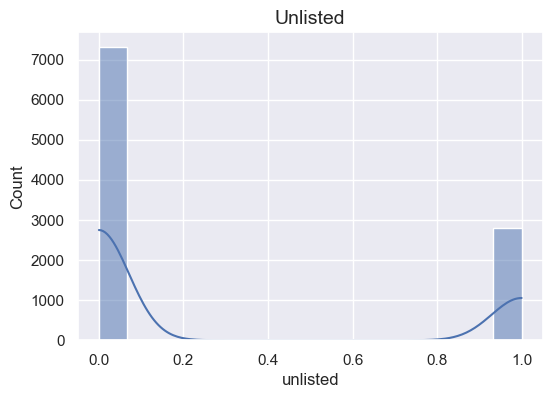

In [70]:
plot_hist(y_train_flat, "Unlisted")

##### Summary

- The dependent variable "unlisted" of the train dataset has two unique values 0 ("still listed") and 1 ("unlisted"). 
- There are no NaN values in the column.
- Approximately 73% of the flats are listed and 27% of the flats are unlisted.

The dataset shows an imbalance, which makes it necessary to observe during the modeling phase its impact on our model's predictions. To address this issue, one potential approach is to apply undersampling on the majority class, "still listed."

### 3.2.2. Independent Variables

#### 3.2.2.1. Exploration of flat dataset

In [71]:
X_train_flat_explo.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10121 entries, 1479 to 11399
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   description                   10121 non-null  object
 1   host_about                    10121 non-null  object
 2   description_translate         10121 non-null  object
 3   host_about_translate          10121 non-null  object
 4   description_translate_tokens  10121 non-null  object
 5   host_about_translate_tokens   10121 non-null  object
dtypes: object(6)
memory usage: 553.5+ KB


In [72]:
# Check for duplicated entries.
print(f"Host about: {X_train_flat_explo.duplicated(['host_about']).sum()} duplicated entries.")
print(f"Thereof {X_train_flat_explo[X_train_flat_explo.duplicated(['host_about'])]['host_about'].nunique()} unique values.")

X_train_flat_explo[X_train_flat_explo.duplicated(["host_about"])].sort_values(by=["host_about"]).head(5)

Host about: 6237 duplicated entries.
Thereof 1428 unique values.


,description,host_about,description_translate,host_about_translate,description_translate_tokens,host_about_translate_tokens
flat_index,,,,,,
1705,A 3 bedroom flat in one of the most modern nei...,\n\n,a bedroom flat in one of the most modern nei...,,"[a, bedroom, flat, in, one, of, the, most, mod...",[]
8553,Room with private bathroom and air conditionin...,\n\n,room with private bathroom and air conditionin...,,"[room, with, private, bathroom, and, air, cond...",[]
4039,Nice and very central apartment. Three bedroom...,\n\n,nice and very central apartment. three bedroom...,,"[nice, and, very, central, apartment, ., three...",[]
5793,"Apartment with 75m2 consisting of 2 bedrooms, ...",\n\n,"apartment with m consisting of bedrooms, ...",,"[apartment, with, m, consisting, of, bedrooms,...",[]
7322,The Historic House of Santo André is a 3-store...,\n\n,the historic house of santo andr is a store...,,"[the, historic, house, of, santo, andr, is, a,...",[]


In [73]:
print(f"Description: {X_train_flat_explo.duplicated(['description']).sum()} duplicated entries")
print(f"Thereof {X_train_flat_explo[X_train_flat_explo.duplicated(['description'])]['description'].nunique()} unique values.")

X_train_flat_explo[X_train_flat_explo.duplicated(["description"])].sort_values(by=["description"]).head(5)

Description: 518 duplicated entries
Thereof 288 unique values.


,description,host_about,description_translate,host_about_translate,description_translate_tokens,host_about_translate_tokens
flat_index,,,,,,
8451,"""Are you really ready to feel like a local?"" S...",Eternal in love for lisbon_x000D_\nMy pleasure...,are you really ready to feel like a local? s...,eternal in love for lisbonmy pleasure is share...,"[are, you, really, ready, to, feel, like, a, l...","[eternal, in, love, for, lisbonmy, pleasure, i..."
4488,"""Are you really ready to feel like a local?"" S...",Eternal in love for lisbon_x000D_\nMy pleasure...,are you really ready to feel like a local? s...,eternal in love for lisbonmy pleasure is share...,"[are, you, really, ready, to, feel, like, a, l...","[eternal, in, love, for, lisbonmy, pleasure, i..."
1968,#FRIENDS WHO HAVEN'T MET YET! <br /><br />We t...,hi everyone\nJust a 22 year old making new fri...,friends who have not met yet! we try to creat...,hi everyone just a year old making new frie...,"[friends, who, have, not, met, yet, !, we, try...","[hi, everyone, just, a, year, old, making, new..."
1936,#FRIENDS WHO HAVEN'T MET YET! <br /><br />We t...,hi everyone\nJust a 22 year old making new fri...,friends who have not met yet! we try to creat...,hi everyone just a year old making new frie...,"[friends, who, have, not, met, yet, !, we, try...","[hi, everyone, just, a, year, old, making, new..."
8938,#FRIENDS WHO HAVEN'T MET YET! <br /><br />We t...,hi everyone\nJust a 22 year old making new fri...,friends who have not met yet! we try to creat...,hi everyone just a year old making new frie...,"[friends, who, have, not, met, yet, !, we, try...","[hi, everyone, just, a, year, old, making, new..."


In [74]:
print(f"NaN values for column")
for col in X_train_flat_explo.columns:
    print(f"{col} = {X_train_flat_explo[col].isna().sum()}")

NaN values for column
description = 0
host_about = 0
description_translate = 0
host_about_translate = 0
description_translate_tokens = 0
host_about_translate_tokens = 0


##### Word and Character count

In [75]:
X_train_flat_explo["description_word_count"] = (X_train_flat_explo["description_translate_tokens"]
                                                .apply(lambda x: word_count(x)))

X_train_flat_explo["host_about_word_count"] = (X_train_flat_explo["host_about_translate_tokens"]
                                               .apply(lambda x: word_count(x)))

X_train_flat_explo["description_character_count"] = (X_train_flat_explo["description_translate_tokens"]
                                                     .apply(lambda x: character_count(x)))

X_train_flat_explo["host_about_character_count"] = (X_train_flat_explo["host_about_translate_tokens"]
                                                    .apply(lambda x: character_count(x)))

X_train_flat_explo.head(2)

,description,host_about,description_translate,host_about_translate,description_translate_tokens,host_about_translate_tokens,description_word_count,host_about_word_count,description_character_count,host_about_character_count
flat_index,,,,,,,,,,
1479,If you want to spend a couple of days or a lon...,"We are the couple J&J who like to receive ""fri...",if you want to spend a couple of days or a lon...,we are the couple j j who like to receive fri...,"[if, you, want, to, spend, a, couple, of, days...","[we, are, the, couple, j, j, who, like, to, re...",50,31,191,125
3655,This outstanding property in charming Cascais ...,"Long Airbnb partner, hosted over 400 guests ov...",this outstanding property in charming cascais ...,"long airbnb partner, hosted over guests ov...","[this, outstanding, property, in, charming, ca...","[long, airbnb, partner, ,, hosted, over, guest...",168,27,781,132


**Word count**

count    10121.000000
mean       119.913546
std         45.323625
min          2.000000
25%         88.000000
50%        139.000000
75%        154.000000
max        264.000000
Name: description_word_count, dtype: float64

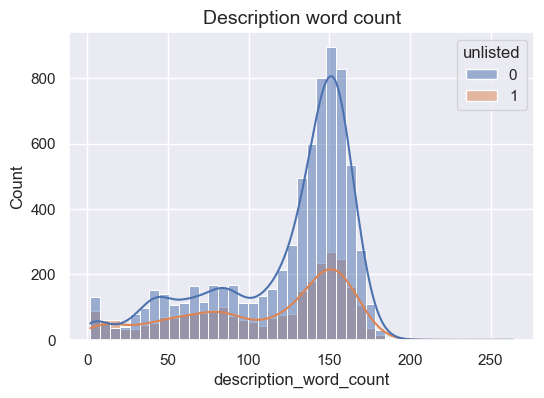

In [76]:
display(X_train_flat_explo.description_word_count.describe())
plot_hist(X_train_flat_explo.description_word_count, 
          "Description word count",
          target=y_train_flat)

count    10121.000000
mean        74.091888
std         78.580595
min          0.000000
25%         26.000000
50%         56.000000
75%        101.000000
max       1381.000000
Name: host_about_word_count, dtype: float64

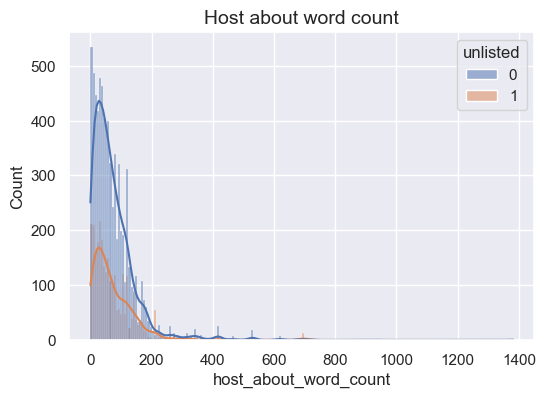

In [77]:
display(X_train_flat_explo.host_about_word_count.describe())
plot_hist(X_train_flat_explo.host_about_word_count, 
          "Host about word count",
          target=y_train_flat)

In [78]:
X_train_flat_explo.sort_values(by=["host_about_word_count"], ascending=False).head(5)

,description,host_about,description_translate,host_about_translate,description_translate_tokens,host_about_translate_tokens,description_word_count,host_about_word_count,description_character_count,host_about_character_count
flat_index,,,,,,,,,,
9715,Bright luxury spacious 3 bedroom apartment in ...,Travel is life ! I love meeting people and hel...,bright luxury spacious bedroom apartment in ...,travel is life ! i love meeting people and hel...,"[bright, luxury, spacious, bedroom, apartment,...","[travel, is, life, !, i, love, meeting, people...",123,1381,628,6019
2245,Gather in the large skylit living room where m...,Travel is life ! I love meeting people and hel...,gather in the large skylit living room where m...,travel is life ! i love meeting people and hel...,"[gather, in, the, large, skylit, living, room,...","[travel, is, life, !, i, love, meeting, people...",94,1381,473,6019
8127,Casal de Santa Maria is a spacious 6 bedroomed...,"Hi, \nMy name is Ralph Mason, I'm a '40 someth...",casal de santa maria is a spacious bedroomed...,"hi, my name is ralph mason, i am a ' someth...","[casal, de, santa, maria, is, a, spacious, bed...","[hi, ,, my, name, is, ralph, mason, ,, i, am, ...",156,930,716,3783
7198,<b>The space</b><br />Double room in a nice lo...,"Portuguese-Mozambican, born in Beira, Mozambiq...",the spacedouble room in a nice location close ...,"portuguese mozambican, born in beira, mozambiq...","[the, spacedouble, room, in, a, nice, location...","[portuguese, mozambican, ,, born, in, beira, ,...",110,880,535,4730
7706,This is a one-bedroom apartment with a bathroo...,CASATRIGOSO: ROLL OUT OF BED AND ONTO THE BEAC...,this is a one bedroom apartment with a bathroo...,casatrigoso roll out of bed and onto the beac...,"[this, is, a, one, bedroom, apartment, with, a...","[casatrigoso, roll, out, of, bed, and, onto, t...",170,798,776,3526


In [79]:
for index in range(5):
    print(f"NEW HOST ABOUT")
    print(X_train_flat_explo.sort_values(by=["host_about_word_count"], 
                                         ascending=False)["host_about_translate"].iloc[index])
    print(f"----------------")

NEW HOST ABOUT
travel is life ! i love meeting people and helping them discover the amazing places i am lucky enough to call home in portugal, malta and the uk.  maybe you will do as i did in      and give up your old life to make one of these magical places home...  when travelling, i believe that paying to stay in a place is a real treat, and when you do so the very least that you should expect is for it to be as comfortable and clean as your own home, if not even better.    for me, that means spaces that not only look amazing, but also cover the basics that are so often missing in airbnb properties such as huge beds with fine linens and      blackout for a great nights sleep, plus air conditioning and luxury amenities.   it is these simple luxuries, plus sparkling clean places, great wifi   smart home tech and fast responsive service that i make sure to provide for my guests.       les voyages c'est la vie ! j'aime rencontrer des gens et les aider   d couvrir mon incroyable ville li

# Hosts with word count > 200: 424
Percentage of hosts with word count > 200 of total dataset: 4.19%


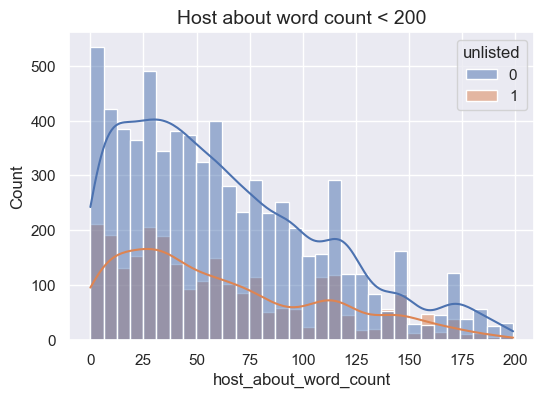

In [80]:
len_of_host_above_200 = len(X_train_flat_explo[X_train_flat_explo.host_about_word_count > 200])

print(f"# Hosts with word count > 200: {len_of_host_above_200}")
print(f"Percentage of hosts with word count > 200 of total dataset: \
{len_of_host_above_200 / len(X_train_flat_explo) * 100:.2f}%")

plot_hist(X_train_flat_explo[X_train_flat_explo.host_about_word_count < 200].host_about_word_count,
          "Host about word count < 200",
          target=y_train_flat)

In [81]:
for index in range(8):
    print(f"NEW HOST ABOUT")
    print(X_train_flat_explo.sort_values(by=["host_about_word_count"], 
                                         ascending=True)["host_about_translate"].iloc[index])
    print(f"----------------")

NEW HOST ABOUT
 
----------------
NEW HOST ABOUT
.
----------------
NEW HOST ABOUT
  
----------------
NEW HOST ABOUT
 
----------------
NEW HOST ABOUT
...
----------------
NEW HOST ABOUT
 
----------------
NEW HOST ABOUT
.....
----------------
NEW HOST ABOUT
 
----------------


**Character count**

count    10121.000000
mean       565.905247
std        209.643434
min          8.000000
25%        411.000000
50%        668.000000
75%        722.000000
max       1286.000000
Name: description_character_count, dtype: float64

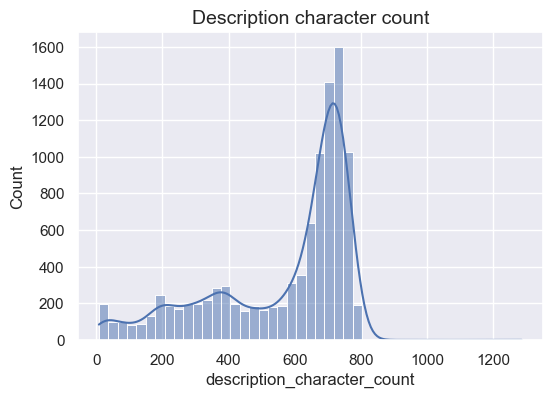

In [82]:
display(X_train_flat_explo.description_character_count.describe())
plot_hist(X_train_flat_explo.description_character_count,"Description character count")

count    10121.000000
mean       330.632447
std        357.519457
min          0.000000
25%        112.000000
50%        240.000000
75%        460.000000
max       6019.000000
Name: host_about_character_count, dtype: float64

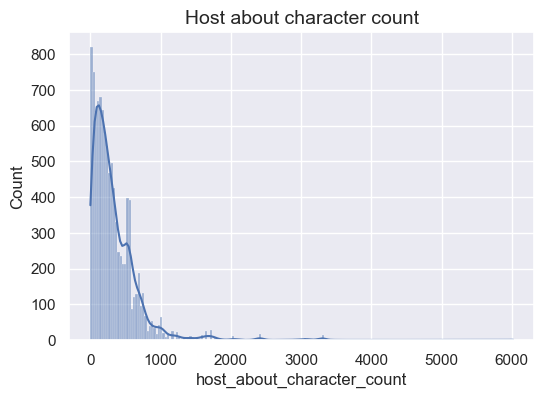

In [83]:
display(X_train_flat_explo.host_about_character_count.describe())
plot_hist(X_train_flat_explo.host_about_character_count,"Host about character count")

##### Stopwords

In [84]:
description_stop_words = extract_stopwords(X_train_flat_explo["description_translate_tokens"])
host_about_stop_words = extract_stopwords(X_train_flat_explo["host_about_translate_tokens"])

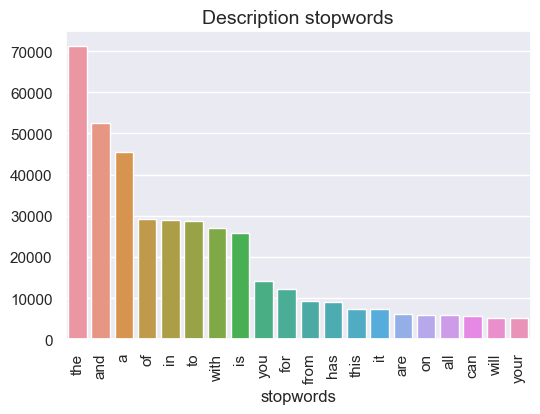

In [85]:
plot_bar(description_stop_words.stopwords.value_counts()[:20], "Description stopwords")

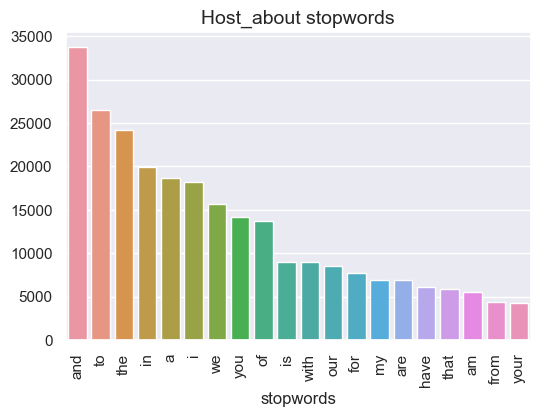

In [86]:
plot_bar(host_about_stop_words.stopwords.value_counts()[:20], "Host_about stopwords")


##### Wordcloud and Word Frequency

Print wordclouds for the description and host about columns to identify most used words.

In [87]:
generate_wordcloud(X_train_flat_explo["description_translate_tokens"],
                   "Description_explo wordcloud",
                   path="./Wordclouds/")

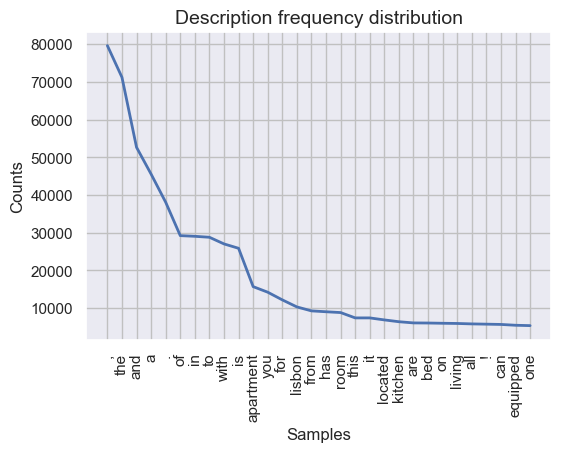

In [88]:
plot_freq_dist(X_train_flat["description_translate_tokens"], "Description frequency distribution")

In [89]:
generate_wordcloud(X_train_flat_explo["host_about_translate_tokens"], 
                                        "Host_about_explo wordcloud",
                                        path="./Wordclouds/")

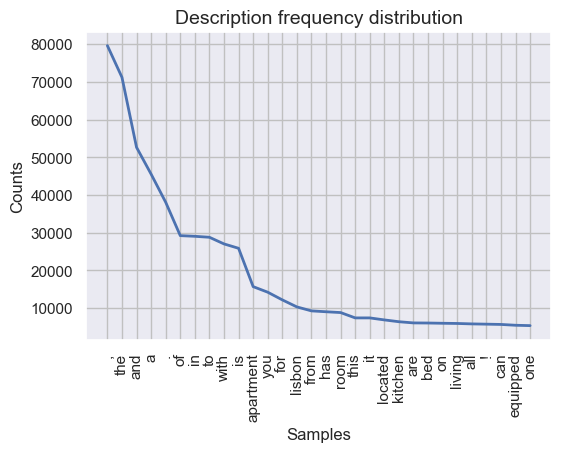

In [90]:
plot_freq_dist(X_train_flat["description_translate_tokens"], "Description frequency distribution")

##### Summary

The dataset has in total 10121 AirBnB flats with originally two columns: description and host_about. Through the previous step of data cleaning we have 4 more columns: the english translations and tokens of both columns.

**Host_about column:**
- One host can have several flats, because some host_about texts are duplicated for different flats.
- Some hosts haven't written anything in the host_about column. There are certain descriptions that cannot be considered as such, since they solely consist of symbols or line breaks.
  
Word and Character count:
  - Average lenght of a description is by 74 words.
  - Majority of the hosts have brief self-descriptions. The highest count of words falls within the 25-75 range.
  - Few 'host_about' texts are extremely long. 424 descriptions have a word count above 200 words, which is only 4.2 % of the dataset.
  - Some hosts have included multiple languages in their self-descriptions, which means that these host_abouts were not correctly translated to English.
  - Certain host descriptions contain information that may not be important to the flat information.

**Description column:**
- Some hosts wrote the same description for different flats, but this only applies for 518 flats.
  
Word and Character count:
  - Average length of a description is by 119 words.
  - Majority of the hosts have longer descriptions. The highest count of words falls within the 125-165 range.

**General:**
- By looking at the relation of the host_about and description column in regards to the unlisted or listed flats, we cannot see significant differences.
- The exploration shows that the most common words are stopwords and punctuation marks. 
- We plan to address stopwords during preprocessing, while we remain with the punctuation, because we hope that model's can comprehend the contextual significance of punctuation and improve the prediction. 
- However, we have identified certain specific words such as 'Lisbon,' 'Portugal,' and district names like 'Bairro Alto' which require preprocessing treatment as well.

#### 3.2.2.2. Exploration of review dataset

In [91]:
train_ds_reviews_explo.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721402 entries, 0 to 721401
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   flat_index                 721402 non-null  int64 
 1   comments                   721398 non-null  object
 2   comments_min_5000_char     721394 non-null  object
 3   comments_translate         721402 non-null  object
 4   comments_translate_tokens  721402 non-null  object
dtypes: int64(1), object(4)
memory usage: 27.5+ MB


In [92]:
print(f"Description: {train_ds_reviews_explo.duplicated(['comments']).sum()} duplicated entries")
print(f"Thereof {train_ds_reviews_explo[train_ds_reviews_explo.duplicated(['comments'])]['comments'].nunique()} unique values.")

train_ds_reviews_explo[train_ds_reviews_explo.duplicated(["comments"])].sort_values(by=["comments"]).head(5)

Description: 15759 duplicated entries
Thereof 3213 unique values.


,flat_index,comments,comments_min_5000_char,comments_translate,comments_translate_tokens
638041,11055,!,!,,[]
225283,3843,!,!,,[]
51893,899,!,!,,[]
301341,5215,!,!,,[]
672760,11670,!,!,,[]


##### Word and Character count

In [93]:
train_ds_reviews_explo["comments_word_count"] = train_ds_reviews_explo["comments_translate_tokens"].apply(
                                                                        lambda x: word_count(x)
                                                                        )

train_ds_reviews_explo["comments_character_count"] = train_ds_reviews_explo["comments_translate_tokens"].apply(
                                                                            lambda x: character_count(x)
                                                                            )
train_ds_reviews_explo.head(2)

,flat_index,comments,comments_min_5000_char,comments_translate,comments_translate_tokens,comments_word_count,comments_character_count
0,1,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...,"[this, is, a, very, cozy, and, comfortable, ho...",25,99
1,1,good<br/>,good<br/>,good,[good],1,4


**Word count**

count    721402.000000
mean         48.372710
std          47.460771
min           0.000000
25%          18.000000
50%          36.000000
75%          64.000000
max        1046.000000
Name: comments_word_count, dtype: float64

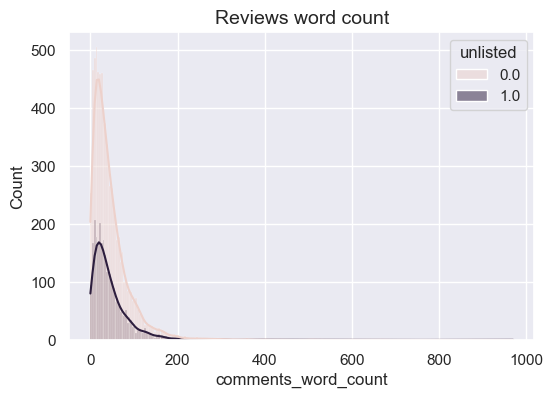

In [94]:
display(train_ds_reviews_explo.comments_word_count.describe())
plot_hist(train_ds_reviews_explo.comments_word_count, 
          "Reviews word count",
          target=y_train_flat)

# Reviews with word count > 200: 10476
Percentage of reviews with word count > 200 of total dataset: 1.45%


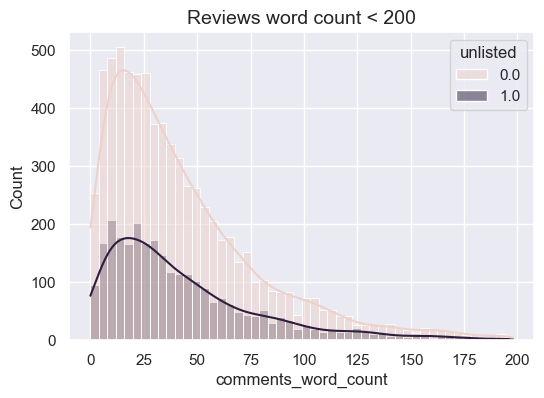

In [95]:
len_of_comments_200 = len(train_ds_reviews_explo[train_ds_reviews_explo.comments_word_count > 200])

print(f"# Reviews with word count > 200: {len_of_comments_200}")
# print how much that is from total number of hosts
print(f"Percentage of reviews with word count > 200 of total dataset: \
{len_of_comments_200 / len(train_ds_reviews_explo) * 100:.2f}%")

plot_hist(train_ds_reviews_explo[train_ds_reviews_explo.comments_word_count < 200].comments_word_count,
          "Reviews word count < 200",
          target=y_train_flat)

In [96]:
for index in range(5):
    print(f"NEW REVIEW ABOUT")
    print(train_ds_reviews_explo.sort_values(by=["comments_word_count"], 
                                         ascending=False)["comments"].iloc[index])
    print(f"----------------")

NEW REVIEW ABOUT
Longe de atender minhas espectativas, vou comentar algumas falhas que a proprietária deveria considerar. <br/>1- Acessibilidade ( deveria mencionar na publicação) a casa não tem acessibilidade para pessoas que depende de uma cadeira de rodas e mães que precisam de um carrinho de bebê. <br/>2- Piscinas ( fora de uso) deveria mencionar no anuncio que uma das piscinas esta desativada, mais especificamente a de crianças, a piscina está abandonada suja e com água podre. Fotos tiradas do apartamento para a piscina são horriveis, pois a piscina de criancas é a que mais aparece na maravilhosa vista. <br/>3- Elevadores (um fora de uso e nada práticos )  são dois elevadores, mas na verdade só funciona um. Eles param entre um andar e outro, novamente tinhamos que descer um lance de escadas com o carrinho de bebê e as malas. <br/>4- Entrada da casa, um pouco vintage e escura, feita em madeira e pouca iluminação, cheiro forte talves da madeira. <br/>5- Iluminacao da casa ( a Ilumin

**Character count**

count    721402.000000
mean        216.422920
std         202.741116
min           0.000000
25%          85.000000
50%         164.000000
75%         283.000000
max        4633.000000
Name: comments_character_count, dtype: float64

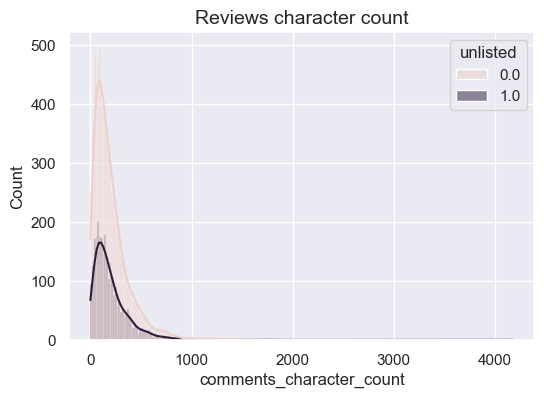

In [97]:
display(train_ds_reviews_explo.comments_character_count.describe())
plot_hist(train_ds_reviews_explo.comments_character_count,
          "Reviews character count",
          target=y_train_flat)

##### Stopwords

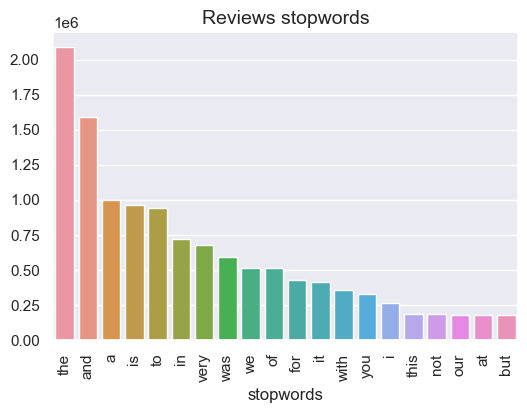

In [98]:
reviews_stop_words = extract_stopwords(train_ds_reviews_explo["comments_translate_tokens"])
plot_bar(reviews_stop_words.stopwords.value_counts()[:20], "Reviews stopwords")

##### Wordcloud and Word Frequency

In [99]:
generate_wordcloud(train_ds_reviews_explo["comments_translate_tokens"], 
                   "Reviews_explo wordcloud",
                   path="./Wordclouds/")

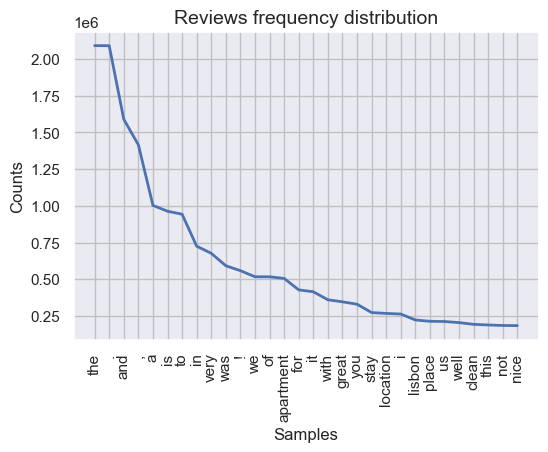

In [100]:
plot_freq_dist(train_ds_reviews_explo["comments_translate_tokens"], "Reviews frequency distribution")

##### Summary

- In the dataset are 721,402 reviews.
- There are certain descriptions that cannot be considered as such, since they solely consist of symbols or line breaks.
- In regards to target variable, we cannot see significant differences between unlisted or listed flats.
- As for the other dataset, the stopwords and punctuation marks are the most common words.
- Also for the reviews we plan to address stopwords during preprocessing, while we remain with the punctuation, because we hope that model's can comprehend the contextual significance of punctuation and improve the prediction.
- As seen in the host_about and description column, specific words like 'Lisbon' appear, which will be treated in the preprocessing step, too.

Word and Character count:
- Average lenght of a comment is by 48 words, however we have a right skewed distribution.
  - Majority of the reviews are short texts. The highest count of words falls within the 0 - 50 range.
  - Few reviews are extremely long. 10476 reviews have a word count above 200 words, but this only represents 1.5 % of the dataset, so it is neglectable.
  - We could not identify that reviews were written in several languages as for the host_about column.


#### 3.2.2.3. Combined Exploration

In [101]:
X_train_flat_explo["number_of_reviews"] = X_train_flat_explo.index.map(\
    lambda x: train_ds_reviews_explo[train_ds_reviews_explo["flat_index"] == x].shape[0])

In [102]:
X_train_flat_explo.number_of_reviews.describe()

count    10121.000000
mean        57.532655
std         89.269676
min          0.000000
25%          0.000000
50%         18.000000
75%         77.000000
max       1175.000000
Name: number_of_reviews, dtype: float64

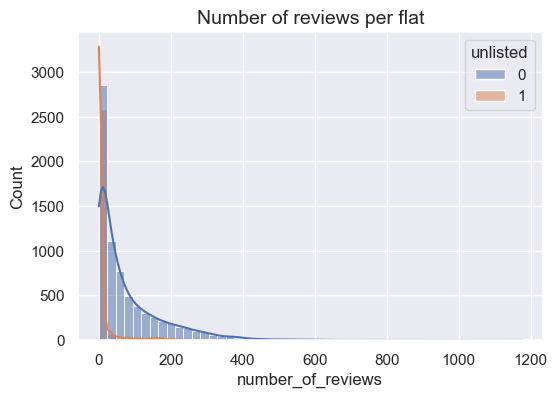

In [103]:
plot_hist(df=X_train_flat_explo.number_of_reviews, 
          title="Number of reviews per flat", 
          target=y_train_flat,
          bins=50)

In [104]:
X_train_flat_explo.sort_values(by=["number_of_reviews"], ascending=False).head(5)

,description,host_about,description_translate,host_about_translate,description_translate_tokens,host_about_translate_tokens,description_word_count,host_about_word_count,description_character_count,host_about_character_count,number_of_reviews
flat_index,,,,,,,,,,,
8911,Double bed room( BLUE).Furnished. Priv toillet...,Easy going person :-) _x000D_who likes to cha...,double bed room blue .furnished. priv toillet...,easy going person x d who likes to cha...,"[double, bed, room, blue, .furnished, ., priv,...","[easy, going, person, x, d, who, likes, to, ch...",102,11,432,41,1175
9374,"<b>The space</b><br />Located in Bica, in the ...",Hi!_x000D_\nI live and love this town and I re...,"the spacelocated in bica, in the historical an...",hi!i live and love this town and i really woul...,"[the, spacelocated, in, bica, ,, in, the, hist...","[hi, !, i, live, and, love, this, town, and, i...",147,48,727,170,896
6720,Commemorating 900 reviews and full 5 star serv...,"We are a couple, from Lisbon. We love this cit...",commemorating reviews and full star serv...,"we are a couple, from lisbon. we love this cit...","[commemorating, reviews, and, full, star, serv...","[we, are, a, couple, ,, from, lisbon, ., we, l...",136,133,631,548,788
3396,<b>The space</b><br />Room located in the quie...,"O MEU LEMA DE VIDA E SER FELIZ, SOU SIMPÁTICA,...",the spaceroom located in the quiet neighborhoo...,"my life motto is to be happy, i am nice, peopl...","[the, spaceroom, located, in, the, quiet, neig...","[my, life, motto, is, to, be, happy, ,, i, am,...",55,41,292,154,765
1147,"Welcoming, with lots of light and right in the...",We are a Portuguese-British couple based in Li...,"welcoming, with lots of light and right in the...",we are a portuguese british couple based in li...,"[welcoming, ,, with, lots, of, light, and, rig...","[we, are, a, portuguese, british, couple, base...",158,59,740,265,678


# Reviews with word count > 200: 846
Percentage of Reviews with word count > 200 of total dataset: 8.36%


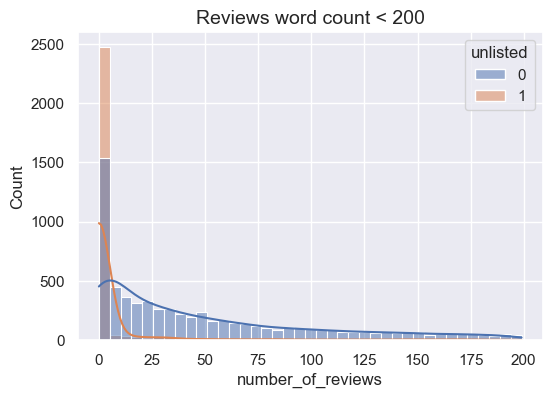

In [105]:
len_of_review_200 = len(X_train_flat_explo[X_train_flat_explo.number_of_reviews > 200])

print(f"# Reviews with word count > 200: {len_of_review_200}")
print(f"Percentage of Reviews with word count > 200 of total dataset: \
{len_of_review_200 / len(X_train_flat_explo) * 100:.2f}%")

plot_hist(X_train_flat_explo[X_train_flat_explo.number_of_reviews < 200].number_of_reviews,
          "Reviews word count < 200",
          target=y_train_flat)

# Reviews with word count < 50: 6761
Percentage of Reviews with word count < 50 of total dataset: 66.80%


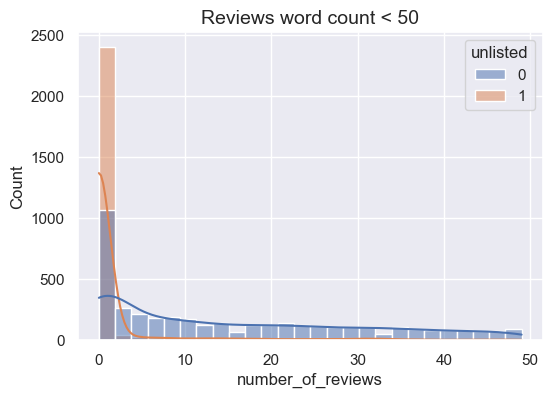

In [106]:
len_of_review_50 = len(X_train_flat_explo[X_train_flat_explo.number_of_reviews < 50])

print(f"# Reviews with word count < 50: {len_of_review_50}")
print(f"Percentage of Reviews with word count < 50 of total dataset: \
{len_of_review_50 / len(X_train_flat_explo) * 100:.2f}%")

plot_hist(X_train_flat_explo[X_train_flat_explo.number_of_reviews < 50].number_of_reviews,
          "Reviews word count < 50",
          target=y_train_flat)

##### Summary


- The average number of reviews per flat is 57.
- There are certain flats that have an exceptionally high number of reviews, with the highest reaching 1175.
- Additionally, there are flats with no reviews at all.
- When filtering for flats with fewer than 50 reviews, there are 6761 flats, which is 67% of the total dataset.
- The majority of unlisted flats either lack reviews entirely or have only a few.

## 3.3. Summary

The exploration reveals some interesting findings:
- Regarding the target variable, the dataset shows an imbalance where the majority class is "still listed". To address this, we will apply undersampling of the majority class for X_train_flat. During the modeling phase, we will compare the performance of the model using the original, non-undersampled training dataset with that of the undersampled dataset, in order to assess the impact on the model's performance.
- Unlisted flats tend to have either no reviews or only a few reviews.
- Some host descriptions contain multiple languages, which we consider outliers and will exclude from the X_train_flat dataset as they were not accurately translated. This only pertains to one host, and removing those rows is acceptable.

We would also like to highlight that, due to the extensive size of the training review dataset, we will not preprocess it. Instead, we will utilize the reviews per flat for sentiment analysis during the feature engineering phase and later merge it with the other training dataset.

# 4. Data Preprocessing

In the preprocessing of the X_train_flat dataset, we will implement the following steps:

- Eliminate the flat with multiple languages in the host about.
- Exclude stopwords.
- Perform lemmatization on the tokens.
- Assign Part of Speech tags to each token.
- Employ Named Entity Recognition to address specific words such as 'Lisbon' and 'Bairro Alto,' among others, at a later stage.

Furthermore we will create the undersampled and non-undersampled datasets. 

## 4.1. Remove outlier

We will remove the flat with the host about in several languages. This affects 2 flats in total with index 9715 and 2245.

In [68]:
print(f"Number of flats with outlier: {len(X_train_flat)}")
# remove from dataset the rows with index 9715 and 2245
X_train_flat.drop([9715, 2245], inplace=True)
y_train_flat.drop([9715, 2245], inplace=True)
print(f"Number of flats without outlier: {len(X_train_flat)}")

Number of flats with outlier: 10121
Number of flats without outlier: 10119


## 4.2. Remove stopwords

In [69]:
X_train_flat = remove_stopwords(X_train_flat, "description_translate_tokens", STOP_WORDS)

X_train_flat = remove_stopwords(X_train_flat, "host_about_translate_tokens", STOP_WORDS)

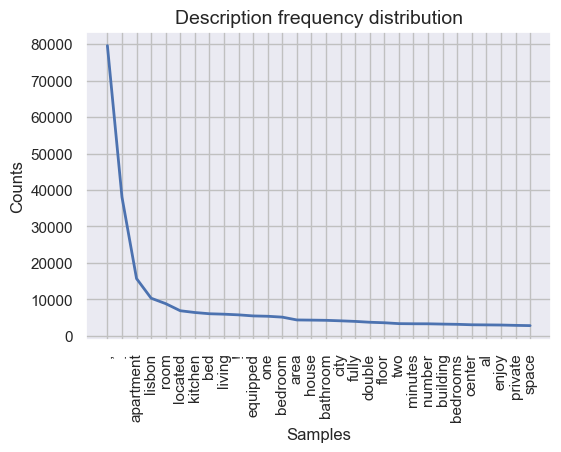

In [70]:
plot_freq_dist(X_train_flat["description_translate_tokens"], "Description frequency distribution")

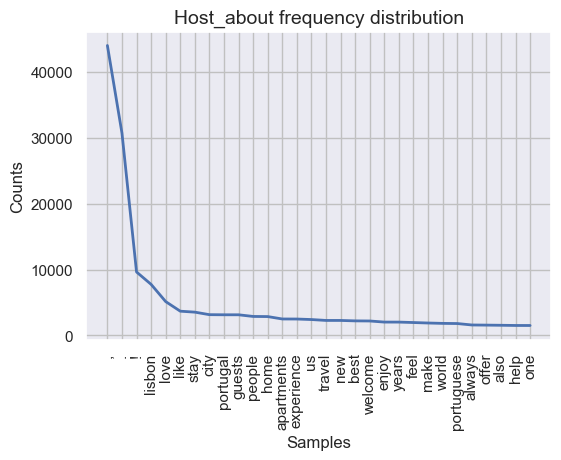

In [72]:
plot_freq_dist(X_train_flat["host_about_translate_tokens"], "Host_about frequency distribution")

## 4.3. Applying a Spacy Pipeline

To process the X_train_flat dataset, a pretrained model from the Spacy library is utilized, providing the following information for the tokens:

- Lemmatization results.
- Part of Speech tags.
- Named Entity recognition tags.
- Word2Vec vectors.

In [ ]:
X_train_flat = spacy_pipe(X_train_flat,
                          "description_translate_tokens",
                          ["description_lemmas", "description_pos", "description_ner", "description_tok2vec"])

X_train_flat = spacy_pipe(X_train_flat,
                          "host_about_translate_tokens",
                          ["host_about_lemmas", "host_about_pos", "host_about_ner", "host_about_tok2vec"])

### 4.3.1. Lemmatization

Generate wordclouds to show the lemmatized tokens.

In [ ]:
generate_wordcloud(X_train_flat["description_lemmas"], 
                   "Description_lemmas wordcloud",
                   path="./Wordclouds/")

generate_wordcloud(X_train_flat["host_about_lemmas"], 
                   "Host_about_lemmas wordcloud",
                   path="./Wordclouds/")

### 4.3.2. Part of Speech Tagging

In [ ]:
X_train_flat[["description_translate_tokens", "description_pos"]].head()

,description_translate_tokens,description_pos
flat_index,,
1479,"[want, spend, couple, days, longer, period, be...","[VERB, VERB, NOUN, NOUN, ADJ, NOUN, ADJ, NOUN,..."
3655,"[outstanding, property, charming, cascais, ide...","[ADJ, NOUN, PROPN, PROPN, ADJ, NOUN, ADJ, NOUN..."
5913,"[exquisite, charming, building, dating, back, ...","[ADJ, ADJ, NOUN, VERB, ADV, NOUN, NOUN, NUM, N..."
6260,"[small, one, bedroom, air, conditioned, apartm...","[ADJ, NUM, NOUN, NOUN, VERB, NOUN, NOUN, ADJ, ..."
8546,"[casa, branca, charming, building, early, twen...","[PROPN, PROPN, PROPN, NOUN, ADJ, ADJ, NOUN, PU..."


In [ ]:
X_train_flat[["host_about_translate_tokens", "host_about_pos"]].head()

,host_about_translate_tokens,host_about_pos
flat_index,,
1479,"[couple, j, j, like, receive, friends, world, ...","[PROPN, PROPN, X, INTJ, VERB, NOUN, NOUN, NOUN..."
3655,"[long, airbnb, partner, ,, hosted, guests, yea...","[ADJ, NOUN, NOUN, PUNCT, VERB, NOUN, NOUN, PUN..."
5913,"[love, lisbon, painting, ., together, sister, ...","[VERB, PROPN, NOUN, PUNCT, ADV, NOUN, PUNCT, V..."
6260,"[hello, ,, jos, mariz, place, going, spend, wo...","[INTJ, PUNCT, PROPN, PROPN, NOUN, VERB, VERB, ..."
8546,"[nia, casa, branca, special, place, feel, like...","[PROPN, PROPN, PROPN, ADJ, PROPN, VERB, ADP, N..."


In [ ]:
pos_tags = set()
for des_pos, host_pos in zip(X_train_flat.description_pos, X_train_flat.host_about_pos):
    for des_pos_tag, host_pos_tag in zip(des_pos, host_pos):
        pos_tags.add(des_pos_tag)
        pos_tags.add(host_pos_tag)

POS tag description

In [ ]:
for pos in pos_tags:
    if pos != "":
        print(f"{pos}: {spacy.explain(pos)}")

PART: particle
SYM: symbol
PUNCT: punctuation
INTJ: interjection
NUM: numeral
PRON: pronoun
X: other
DET: determiner
PROPN: proper noun
SCONJ: subordinating conjunction
ADP: adposition
ADJ: adjective
ADV: adverb
CCONJ: coordinating conjunction
VERB: verb
AUX: auxiliary
NOUN: noun


### 4.3.3. Name Entitiy Recognition

In [ ]:
X_train_flat[["description_translate_tokens", "description_ner"]].head()

,description_translate_tokens,description_ner
flat_index,,
1479,"[want, spend, couple, days, longer, period, be...","[[, O], [, O], [DATE, B], [DATE, I], [, O], [,..."
3655,"[outstanding, property, charming, cascais, ide...","[[, O], [, O], [, O], [, O], [, O], [, O], [, ..."
5913,"[exquisite, charming, building, dating, back, ...","[[, O], [, O], [, O], [, O], [, O], [DATE, B],..."
6260,"[small, one, bedroom, air, conditioned, apartm...","[[, O], [CARDINAL, B], [, O], [, O], [, O], [,..."
8546,"[casa, branca, charming, building, early, twen...","[[PERSON, B], [PERSON, I], [, O], [, O], [DATE..."


In [ ]:
X_train_flat[["host_about_translate_tokens", "host_about_ner"]].head()

,host_about_translate_tokens,host_about_ner
flat_index,,
1479,"[couple, j, j, like, receive, friends, world, ...","[[, O], [, O], [, O], [, O], [, O], [, O], [, ..."
3655,"[long, airbnb, partner, ,, hosted, guests, yea...","[[, O], [, O], [, O], [, O], [, O], [, O], [DA..."
5913,"[love, lisbon, painting, ., together, sister, ...","[[, O], [PERSON, B], [, O], [, O], [, O], [, O..."
6260,"[hello, ,, jos, mariz, place, going, spend, wo...","[[, O], [, O], [PERSON, B], [PERSON, I], [PERS..."
8546,"[nia, casa, branca, special, place, feel, like...","[[PERSON, B], [PERSON, I], [PERSON, I], [, O],..."


In [ ]:
# Get all NER tags from the dataset
ner_tags = set()
for des_ner, host_ner in zip(X_train_flat.description_ner, X_train_flat.host_about_ner):
    for des_ner_tag, host_ner_tag in zip(des_ner, host_ner):
        ner_tags.add(des_ner_tag[0])
        ner_tags.add(host_ner_tag[0])

NER tag description

In [ ]:
for ner in ner_tags:
    if ner != "":
        print(f"{ner}: {spacy.explain(ner)}")

GPE: Countries, cities, states
NORP: Nationalities or religious or political groups
LOC: Non-GPE locations, mountain ranges, bodies of water
PRODUCT: Objects, vehicles, foods, etc. (not services)
PERCENT: Percentage, including "%"
CARDINAL: Numerals that do not fall under another type
QUANTITY: Measurements, as of weight or distance
TIME: Times smaller than a day
FAC: Buildings, airports, highways, bridges, etc.
LAW: Named documents made into laws.
EVENT: Named hurricanes, battles, wars, sports events, etc.
PERSON: People, including fictional
DATE: Absolute or relative dates or periods
LANGUAGE: Any named language
ORDINAL: "first", "second", etc.
WORK_OF_ART: Titles of books, songs, etc.
ORG: Companies, agencies, institutions, etc.


### 4.3.4. Split the X_train_flat

After completing the previous steps, we will divide the dataset into two parts:
The first part will include the lemmatized tokens, POS tags, and NER tags. In this dataset, our goal is to exchange the tokens identified by Spacy as named entitity with their corresponding tags. Additionally, we will replace punctuation with the POS tag "PUNCT" to ensure the model understands the separators between texts and the potential variation in context. This dataset will be utilized in Feature Engineering to generate word embeddings such as Word2Vec or GloVe, as well as for TF-IDF.

The second part will consist of the Word2Vec vectors from the Spacy pipeline. These vectors are based on the unlemmatized tokens and have not undergone any replacement of NER or POS tags. Our approach involves calculating the average vector representation for each flat's description and host bio. These averaged vectors, along with other features, will be passed into a classifier in the modelling stage.

In [ ]:
column_list = ["description_lemmas",  "description_pos", "description_ner", 
               "host_about_lemmas", "host_about_pos", "host_about_ner"]

X_train_flat_preprocessed = X_train_flat[column_list].copy()
X_train_flat_preprocessed.rename(columns={"description_lemmas": "description_tokens", 
                                           "host_about_lemmas": "host_about_tokens"}, inplace=True)

X_train_flat_preprocessed.head(2)

,description_tokens,description_pos,description_ner,host_about_tokens,host_about_pos,host_about_ner
flat_index,,,,,,
1479,"[want, spend, couple, day, long, period, beaut...","[VERB, VERB, NOUN, NOUN, ADJ, NOUN, ADJ, NOUN,...","[[, O], [, O], [DATE, B], [DATE, I], [, O], [,...","[couple, j, j, like, receive, friend, world, m...","[PROPN, PROPN, X, INTJ, VERB, NOUN, NOUN, NOUN...","[[, O], [, O], [, O], [, O], [, O], [, O], [, ..."
3655,"[outstanding, property, charming, cascais, ide...","[ADJ, NOUN, PROPN, PROPN, ADJ, NOUN, ADJ, NOUN...","[[, O], [, O], [, O], [, O], [, O], [, O], [, ...","[long, airbnb, partner, ,, host, guest, year, ...","[ADJ, NOUN, NOUN, PUNCT, VERB, NOUN, NOUN, PUN...","[[, O], [, O], [, O], [, O], [, O], [, O], [DA..."


In [ ]:
column_list = ["description_tok2vec", "host_about_tok2vec"]

X_train_flat_word2vec = X_train_flat[column_list].copy()

X_train_flat_word2vec.head(2)

,description_tok2vec,host_about_tok2vec
flat_index,,
1479,"[[4.3092, 6.3754, -6.2211, -3.7061, -1.344, 0....","[[-2.1424, -3.2725, -0.50777, 2.4322, -0.8902,..."
3655,"[[-1.6609, -1.2908, -1.7052, -1.6114, 4.8477, ...","[[0.52571, 4.0515, -5.3267, 4.5004, 2.4807, 1...."


### 4.3.5. Mean value for vectors

It appears, that Spacy generated some NaN values for some flats in the dataset. We will remove these flats later in the modelling phase.

In [ ]:
for column in ["description_tok2vec", "host_about_tok2vec"]:
    X_train_flat_word2vec[column] = X_train_flat_word2vec[column]\
                                    .apply(lambda x: mean_vector(x))

X_train_flat_word2vec.head(2)

c:\ProgramData\Anaconda3\envs\textmining\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,description_tok2vec,host_about_tok2vec
flat_index,,
1479,-0.020244,-0.125995
3655,-0.079593,-0.169740


In [ ]:
X_train_flat_word2vec.isna().sum()

description_tok2vec     0
host_about_tok2vec     55
dtype: int64

### 4.3.4. Treatment of tokens with POS and NER

In [ ]:
for column in ["description", "host_about"]:
    X_train_flat_preprocessed[column + "_tokens"] = X_train_flat_preprocessed.apply(
        lambda x: replace_ner(x[column + "_tokens"], x[column + "_ner"]), axis=1)

for column in ["description", "host_about"]:
    X_train_flat_preprocessed[column + "_tokens"] = X_train_flat_preprocessed.apply(
        lambda x: replace_punctuation(x[column + "_tokens"], x[column + "_pos"]), axis=1)

X_train_flat_preprocessed.head(2)

,description_tokens,description_pos,description_ner,host_about_tokens,host_about_pos,host_about_ner
flat_index,,,,,,
1479,"[want, spend, date, date, long, period, beauti...","[VERB, VERB, NOUN, NOUN, ADJ, NOUN, ADJ, NOUN,...","[[, O], [, O], [DATE, B], [DATE, I], [, O], [,...","[couple, j, j, like, receive, friend, world, m...","[PROPN, PROPN, X, INTJ, VERB, NOUN, NOUN, NOUN...","[[, O], [, O], [, O], [, O], [, O], [, O], [, ..."
3655,"[outstanding, property, charming, cascais, ide...","[ADJ, NOUN, PROPN, PROPN, ADJ, NOUN, ADJ, NOUN...","[[, O], [, O], [, O], [, O], [, O], [, O], [, ...","[long, airbnb, partner, punct, host, guest, da...","[ADJ, NOUN, NOUN, PUNCT, VERB, NOUN, NOUN, PUN...","[[, O], [, O], [, O], [, O], [, O], [, O], [DA..."


## 4.4. Undersampling

Undersampling is applied on the X_train_flat_preprocessed dataset on the majority class to create a balanced dataset. The library [imbalanced-learn](https://imbalanced-learn.org/stable/) is used for the random undersampling.

In [97]:
undersample = RandomUnderSampler(random_state = SEED, sampling_strategy='majority')
# fit and apply the transform
X_train_flat_undersample, y_train_flat_undersample = undersample.fit_resample(X_train_flat_preprocessed, y_train_flat)
X_train_flat_undersample["flat_index"] = undersample.sample_indices_
y_train_flat_undersample = y_train_flat_undersample.set_axis(undersample.sample_indices_)

X_train_flat_undersample.set_index("flat_index", inplace=True)

## 4.5. Summary

We created following datasets:
- X_train_flat_word2vec
  - averaged Word2Vec for description and host_about (non-lemmatized and not punctuation and NER treated tokens)
- X_train_flat_preprocessed:
  - lemmatized, punctuation and NER treated tokens
  - POS tags
  - NER tags
- X_train_flat_undersample:
  - undersampled X_train_flat_preprocessed

# 5. Feature Engineering

In this part we will do the following steps:
- Create TF-IDF vectors from the X_train datasets and apply PCA on top of it to reduce the number of input features for the classifiers
- Sentimental Analysis of the train_ds_reviews dataset
- Glove and Word2Vec embeddings for X_train datasets

## 5.1. TF-IDF Vectors

### 5.1.1. Non-undersampled dataset

#### 5.1.1.1 TF-IDF

In [51]:
tfidf_model = fit_train_tfidf(X_train_flat_preprocessed, ['description_tokens', "host_about_tokens"])

X_train_flat_tfidf = create_tfidf_dataframe(X_train_flat_preprocessed, ['description_tokens', "host_about_tokens"], tfidf_model)

#### 5.1.1.2 PCA

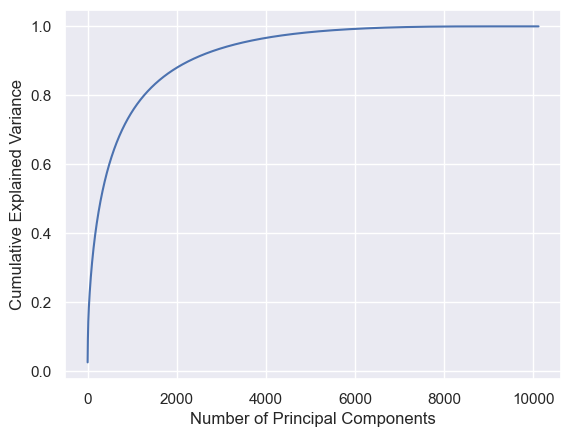

Optimal number of principal components: 3380


In [ ]:
pca = PCA()
pca.fit(X_train_flat_tfidf)

# Calculate the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Find the optimal number of principalcomponents based on a threshold.
threshold = 0.95
optimal_n_components = np.where(cumulative_explained_variance >= threshold)[0][0] + 1

print(f'Optimal number of principal components: {optimal_n_components}')

In [64]:
n_components = 3380 
pca = PCA(n_components=n_components)
X_train_flat_tfidf_pca = pca.fit_transform(X_train_flat_tfidf)

save_model(pca, 'PCA')

X_train_flat_tfidf_pca = pd.DataFrame(X_train_flat_tfidf_pca, columns=[f'PC{i+1}' for i in range(n_components)])

### 5.1.2. Undersampled dataset

#### 5.1.2.1. TF-IDF

In [101]:
tfidf_model = fit_train_tfidf(X_train_flat_undersample, ['description_tokens', "host_about_tokens"])

X_train_flat_tfidf_undersample = create_tfidf_dataframe(X_train_flat_undersample, ['description_tokens', "host_about_tokens"], tfidf_model)

#### 5.1.2.2. PCA

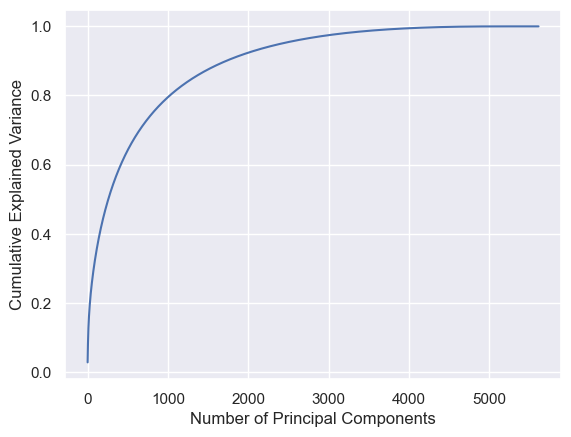

Optimal number of principal components: 2408


In [69]:
# Apply PCA to the TF-IDF DataFrame
pca = PCA()
pca.fit(X_train_flat_tfidf_undersample)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

threshold = 0.95
optimal_n_components = np.where(cumulative_explained_variance >= threshold)[0][0] + 1

print(f'Optimal number of principal components: {optimal_n_components}')

In [103]:
n_components = 2408
pca = PCA(n_components=n_components)
X_train_flat_tfidf_pca_undersample = pca.fit_transform(X_train_flat_tfidf_undersample)

save_model(pca, 'PCA_undersample')

X_train_flat_tfidf_pca_undersample = pd.DataFrame(X_train_flat_tfidf_pca_undersample, columns=[f'PC{i+1}' for i in range(n_components)])

## 5.2. Sentiment Analysis

In [ ]:
train_ds_reviews_sentimental = sentimetal_analysis(train_ds_reviews, "comments_translate", SENTIMENTAL_PIPELINE)
train_ds_reviews_sentimental.head()

,comments,comments_min_5000_char,comments_translate,comments_translate_tokens,label,score
flat_index,,,,,,
1,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...,"['this', 'is', 'a', 'very', 'cozy', 'and', 'co...",POSITIVE,0.999756
1,Estão de parabéns super indico.,Estão de parabéns super indico.,they are to be congratulated super indica.,"['they', 'are', 'to', 'be', 'congratulated', '...",POSITIVE,0.996580
1,Great stay! Would recommend,Great stay! Would recommend,great stay! would recommend,"['great', 'stay', '!', 'would', 'recommend']",POSITIVE,0.999752
1,"Un lugar muy acogedor, buen lugar donde hosped...","Un lugar muy acogedor, buen lugar donde hosped...","a very cozy place, a good place to stay, very ...","['a', 'very', 'cozy', 'place', ',', 'a', 'good...",POSITIVE,0.999725
1,Nice time and nice place where you can rest an...,Nice time and nice place where you can rest an...,nice time and nice place where you can rest an...,"['nice', 'time', 'and', 'nice', 'place', 'wher...",POSITIVE,0.999878


In [ ]:
count_total = train_ds_reviews_sentimental['comments'].shape[0]
count_pos = train_ds_reviews_sentimental[train_ds_reviews_sentimental['label'] == 'POSITIVE'].shape[0]
count_neg = train_ds_reviews_sentimental[train_ds_reviews_sentimental['label'] == 'NEGATIVE'].shape[0]
count_pos_90 = train_ds_reviews_sentimental[(train_ds_reviews_sentimental['label'] == 'POSITIVE') & (train_ds_reviews_sentimental['score']<0.90)].shape[0]
count_neg_90 = train_ds_reviews_sentimental[(train_ds_reviews_sentimental['label'] == 'NEGATIVE') & (train_ds_reviews_sentimental['score']<0.90)].shape[0]
count_pos_60 = train_ds_reviews_sentimental[(train_ds_reviews_sentimental['label'] == 'POSITIVE') & (train_ds_reviews_sentimental['score']<0.60)].shape[0]
count_neg_60 = train_ds_reviews_sentimental[(train_ds_reviews_sentimental['label'] == 'NEGATIVE') & (train_ds_reviews_sentimental['score']<0.60)].shape[0]
count_90 = train_ds_reviews_sentimental[train_ds_reviews_sentimental['score']<0.90].shape[0]
count_60 = train_ds_reviews_sentimental[train_ds_reviews_sentimental['score']<0.60].shape[0]

print(f"Percentage of Total bellow 90 is {(count_90/count_total)*100:.2f}%")
print(f"Percentage of Total bellow 60 is {(count_60/count_total)*100:.2f}%")
print(f"Percentage of Positive bellow 90 is {(count_pos_90/count_pos)*100:.2f}%")
print(f"Percentage of Negative bellow 90 is {(count_neg_90/count_neg)*100:.2f}%")
print(f"Percentage of Positive bellow 60 is {(count_pos_60/count_pos)*100:.2f}%")
print(f"Percentage of Negative bellow 60 is {(count_neg_60/count_neg)*100:.2f}%")

Percentage of Total bellow 90 is 2.27%
Percentage of Total bellow 60 is 0.35%
Percentage of Positive bellow 90 is 1.37%
Percentage of Negative bellow 90 is 18.30%
Percentage of Positive bellow 60 is 0.18%
Percentage of Negative bellow 60 is 3.26%


In [ ]:
train_ds_reviews_sentimental = (pd.concat([train_ds_reviews_sentimental, pd.get_dummies(train_ds_reviews_sentimental['label'])], axis=1)
                                .groupby(['flat_index']).agg({'NEGATIVE':'sum','POSITIVE':'sum'}))
train_ds_reviews_sentimental.head()

,NEGATIVE,POSITIVE
flat_index,,
1,6,44
5,1,40
8,3,165
9,2,31
10,2,11


## 5.3. Word2Vec embedding

### 5.3.1. Non-undersampled dataset

In [ ]:
X_train_preprocess_word2vec = word2vec_pipe(X_train_flat_preprocessed.copy(),
                                          ["description_tokens","host_about_tokens"],
                                          ["description_tok2vec", "host_about_tok2vec"])

In [77]:
X_train_preprocess_word2vec.head()

,description_tok2vec,host_about_tok2vec
flat_index,,
1479,0.021494,-0.067420
3655,-0.040213,-0.096146
5913,-0.001091,-0.039669
6260,-0.064576,-0.066327
8546,0.001978,-0.061319


### 5.3.2. Undersampled dataset

In [ ]:
X_train_preprocess_word2vec_undersample = word2vec_pipe(X_train_flat_undersample.copy(),
                                          ["description_tokens","host_about_tokens"],
                                          ["description_tok2vec", "host_about_tok2vec"])

In [106]:
X_train_preprocess_word2vec_undersample.head()

,description_tok2vec,host_about_tok2vec
flat_index,,
8071,-0.010616,-0.167703
2166,-0.039531,-0.162307
9940,-0.071511,-0.075775
3894,-0.035583,-0.036138
6772,-0.051385,-0.158467


## 5.4. GloVe embedding

### 5.4.1. Non-undersampled dataset

In [132]:
X_train_glove = create_glove(X_train_flat_preprocessed, ["description_tokens", "host_about_tokens"])

In [133]:
X_train_glove.head()

,glove_description_tokens,glove_host_about_tokens
flat_index,,
1479,"[[tensor(0.1363), tensor(-0.0545), tensor(0.37...","[[tensor(0.4556), tensor(0.5434), tensor(-0.31..."
3655,"[[tensor(-0.9802), tensor(1.0182), tensor(-0.4...","[[tensor(0.4696), tensor(0.8296), tensor(-0.13..."
5913,"[[tensor(0.3171), tensor(0.3636), tensor(-1.64...","[[tensor(-0.1389), tensor(1.1401), tensor(-0.8..."
6260,"[[tensor(1.1419), tensor(0.2162), tensor(0.059...","[[tensor(-0.3850), tensor(0.8009), tensor(0.06..."
8546,"[[tensor(0.6173), tensor(0.4004), tensor(0.067...","[[tensor(0.6173), tensor(0.4004), tensor(0.067..."


### 5.4.2. Undersampled dataset

In [135]:
X_train_glove_undersample = create_glove(X_train_flat_undersample, ["description_tokens", "host_about_tokens"])

In [136]:
X_train_glove_undersample.head()

,glove_description_tokens,glove_host_about_tokens
flat_index,,
8071,"[[tensor(0.2019), tensor(0.8061), tensor(-1.12...","[[tensor(0.3681), tensor(0.2083), tensor(-0.22..."
2166,"[[tensor(0.2330), tensor(0.4588), tensor(0.266...","[[tensor(0.3693), tensor(-0.4845), tensor(-0.0..."
9940,"[[tensor(1.5666), tensor(0.5775), tensor(0.801...","[[tensor(-0.3850), tensor(0.8009), tensor(0.06..."
3894,"[[tensor(0.6443), tensor(1.0996), tensor(-0.94...","[[tensor(0.9553), tensor(-0.0116), tensor(0.07..."
6772,"[[tensor(0.5327), tensor(0.0159), tensor(-0.05...","[[tensor(0.3681), tensor(0.2083), tensor(-0.22..."


## 5.5. Summary

After the feature engineering we have following datasets for the non-undersampled and undersampled train dataset:

- X_train_flat_tfidf_pca
  - TF-IDF vectors with PCA
- X_train_preprocess_word2vec
  - Word2Vec embedding applied on preprocessed X_train_flat
- X_train_glove
  - Glove embedding applied on preprocessed X_train_flat

Furthermore the train_reviews_sentimental_count dataset consist of the quantities of positive and negative reviews per flat.

# 6. Modeling

In [ ]:
# Prepare the validation and test datasets for the different approaches.
X_val_preprocessed, X_val_preprocess_word2vec, X_val_tfidf_pca, X_val_glove = create_vectors(X_val_flat, tfidf_model, pca, pca_components=3380)

X_test_preprocessed, X_test_preprocess_word2vec, X_test_tfidf_pca, X_test_glove = create_vectors(X_test_flat, tfidf_model, pca, pca_components=3380)

In [66]:
# Define the classifiers used for the approaches.
n_jobs = -1

classifier = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(random_state=SEED, n_jobs=n_jobs, max_depth=10, n_estimators=100),
    "KNN": KNeighborsClassifier(n_jobs=n_jobs),
}

## 6.1. First Approach

**Dataset:**
Word2Vec generated from the Spacy pipeline (unlemmatized, no POS and NER tags implemented)

**Models:**
Logistic Regression, KNN, Random Forest

In [58]:
# Create Word2Vec embedding with Spacy pipeline for validation and test dataset and join with reviews.
X_val_flat_word2vec = clean_dataset(X_val_flat, train_flag=True)
X_test_flat_word2vec = clean_dataset(X_test_flat, train_flag=True)

X_val_flat_word2vec = word2vec_pipe(X_val_flat_word2vec.copy(),
                                    ["description_translate_tokens","host_about_translate_tokens"],
                                    ["description_tok2vec", "host_about_tok2vec"])

X_test_flat_word2vec = word2vec_pipe(X_test_flat_word2vec.copy(),
                                    ["description_translate_tokens","host_about_translate_tokens"],
                                    ["description_tok2vec", "host_about_tok2vec"])

Cleaned dataset.
Cleaned dataset.


In [61]:
y_train_flat_word2vec = y_train_flat.copy().sort_index()
y_val_flat_word2vec = y_val_flat.copy().sort_index()
y_test_flat_word2vec = y_test_flat.copy().sort_index()

In [62]:
# Removes the NaN values created by the mean calculation of the vectors.
remove_nans(X_train_flat_word2vec, y_train_flat_word2vec)
remove_nans(X_val_flat_word2vec, y_val_flat_word2vec)
remove_nans(X_test_flat_word2vec, y_test_flat_word2vec)

In [63]:
# Join the sentimental count to the word2vec vectors.
X_train_flat_word2vec = join_reviews(X_train_flat_word2vec, train_reviews_sentimental_count).sort_index()
X_val_flat_word2vec = join_reviews(X_val_flat_word2vec, train_reviews_sentimental_count).sort_index()
X_test_flat_word2vec = join_reviews(X_test_flat_word2vec, train_reviews_sentimental_count).sort_index()

In [74]:
forest_word2vec, forest_pipe_word2vec = train_classifier(classifier["RandomForestClassifier"],
                                                    X_train=X_train_flat_word2vec,
                                                    y_train=y_train_flat_word2vec,
                                                    X_val=X_val_flat_word2vec,
                                                    y_val=y_val_flat_word2vec,
                                                    X_test=X_test_flat_word2vec,
                                                    y_test=y_test_flat_word2vec,
                                                    save_model_name="randomforest_word2vec")
forest_word2vec.T

train                                                 val  \
                  0         1 accuracy  macro avg weighted avg        0   
precision     0.945     0.770    0.891      0.858        0.896    0.932   
recall        0.901     0.863    0.891      0.882        0.891    0.884   
f1-score      0.922     0.814    0.891      0.868        0.892    0.907   
support    7269.000  2795.000    0.891  10064.000    10064.000  809.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.734     0.87     0.833        0.877    0.928    0.726    0.865   
recall       0.833     0.87     0.858        0.870    0.881    0.823    0.865   
f1-score     0.780     0.87     0.844        0.872    0.904    0.772    0.865   
support    311.000     0.87  1120.000     1120.000  899.000  345.000    0.865   

                                  
          macro avg weighted avg  
precision     0.827        0.872  
recall        0.852        0.865  
f1-score      0.838        0.867  
support    1244.000     1244.000

In [75]:
logreg_word2vec, logreg_pipe_word2vec = train_classifier(classifier["LogisticRegression"],
                                                    X_train=X_train_flat_word2vec,
                                                    y_train=y_train_flat_word2vec,
                                                    X_val=X_val_flat_word2vec,
                                                    y_val=y_val_flat_word2vec,
                                                    X_test=X_test_flat_word2vec,
                                                    y_test=y_test_flat_word2vec,
                                                    save_model_name="logreg_word2vec")
logreg_word2vec.T

train                                                 val  \
                  0         1 accuracy  macro avg weighted avg        0   
precision     0.738     0.668    0.735      0.703        0.718    0.743   
recall        0.982     0.093    0.735      0.537        0.735    0.984   
f1-score      0.843     0.163    0.735      0.503        0.654    0.847   
support    7269.000  2795.000    0.735  10064.000    10064.000  809.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.735    0.743     0.739        0.741    0.753    0.828    0.756   
recall       0.116    0.743     0.550        0.743    0.988    0.154    0.756   
f1-score     0.200    0.743     0.523        0.667    0.854    0.259    0.756   
support    311.000    0.743  1120.000     1120.000  899.000  345.000    0.756   

                                  
          macro avg weighted avg  
precision     0.790        0.774  
recall        0.571        0.756  
f1-score      0.557        0.689  
support    1244.000     1244.000

In [76]:
knn_word2vec, knn_pipe_word2vec = train_classifier(classifier["KNN"],
                                            X_train=X_train_flat_word2vec,
                                            y_train=y_train_flat_word2vec,
                                            X_val=X_val_flat_word2vec,
                                            y_val=y_val_flat_word2vec,
                                            X_test=X_test_flat_word2vec,
                                            y_test=y_test_flat_word2vec,
                                            save_model_name="knn_word2vec")
knn_word2vec.T

train                                                 val  \
                  0         1 accuracy  macro avg weighted avg        0   
precision     0.921     0.813    0.892      0.867        0.891    0.899   
recall        0.930     0.793    0.892      0.861        0.892    0.906   
f1-score      0.925     0.803    0.892      0.864        0.891    0.903   
support    7269.000  2795.000    0.892  10064.000    10064.000  809.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.751    0.859     0.825        0.858    0.897    0.713    0.844   
recall       0.736    0.859     0.821        0.859    0.887    0.733    0.844   
f1-score     0.744    0.859     0.823        0.859    0.891    0.723    0.844   
support    311.000    0.859  1120.000     1120.000  899.000  345.000    0.844   

                                  
          macro avg weighted avg  
precision     0.805        0.846  
recall        0.810        0.844  
f1-score      0.807        0.845  
support    1244.000     1244.000

## 6.2. Second Approach

**Dataset:**
Word2Vec generated from Spacy, lemmatized, POS and NER treated

**Models:**
Logistic Regression, KNN, Random Forest

In [62]:
y_train_preprocess_word2vec = y_train_flat.copy().sort_index()
y_val_preprocess_word2vec = y_val_flat.copy().sort_index()
y_test_preprocess_word2vec = y_test_flat.copy().sort_index()

In [63]:
# Removes the NaN values created by the mean calculation of the vectors.
remove_nans(X_train_preprocess_word2vec, y_train_preprocess_word2vec)
remove_nans(X_val_preprocess_word2vec, y_val_preprocess_word2vec)
remove_nans(X_test_preprocess_word2vec, y_test_preprocess_word2vec)

In [64]:
# Join the sentimental count to the word2vec vectors.
X_train_preprocess_word2vec = join_reviews(X_train_preprocess_word2vec, train_reviews_sentimental_count).sort_index()
X_val_preprocess_word2vec = join_reviews(X_val_preprocess_word2vec, train_reviews_sentimental_count).sort_index()
X_test_preprocess_word2vec = join_reviews(X_test_preprocess_word2vec, train_reviews_sentimental_count).sort_index()

In [70]:
forest_preprocess_word2vec, forest_pipe_preprocess_word2vec = train_classifier(classifier["RandomForestClassifier"],
                                                                            X_train=X_train_preprocess_word2vec,
                                                                            y_train=y_train_preprocess_word2vec,
                                                                            X_val=X_val_preprocess_word2vec,
                                                                            y_val=y_val_preprocess_word2vec,
                                                                            X_test=X_test_preprocess_word2vec,
                                                                            y_test=y_test_preprocess_word2vec,
                                                                            save_model_name="randomforest_word2vec_preprocess")
forest_preprocess_word2vec.T

train                                                 val  \
                  0         1 accuracy  macro avg weighted avg        0   
precision     0.944     0.767    0.889      0.855        0.895    0.936   
recall        0.899     0.862    0.889      0.880        0.889    0.899   
f1-score      0.921     0.811    0.889      0.866        0.891    0.917   
support    7269.000  2795.000    0.889  10064.000    10064.000  809.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.761    0.882     0.848        0.887    0.929    0.745    0.873   
recall       0.839    0.882     0.869        0.882    0.892    0.823    0.873   
f1-score     0.798    0.882     0.857        0.884    0.910    0.782    0.873   
support    311.000    0.882  1120.000     1120.000  898.000  345.000    0.873   

                                  
          macro avg weighted avg  
precision     0.837        0.878  
recall        0.858        0.873  
f1-score      0.846        0.875  
support    1243.000     1243.000

In [83]:
logreg_preprocess_word2vec, logreg_pipe_preprocess_word2vec = train_classifier(classifier["LogisticRegression"],
                                                                            X_train=X_train_preprocess_word2vec,
                                                                            y_train=y_train_preprocess_word2vec,
                                                                            X_val=X_val_preprocess_word2vec,
                                                                            y_val=y_val_preprocess_word2vec,
                                                                            X_test=X_test_preprocess_word2vec,
                                                                            y_test=y_test_preprocess_word2vec,
                                                                            save_model_name="logreg_word2vec_preprocess")
logreg_preprocess_word2vec.T

train                                                 val  \
                  0         1 accuracy  macro avg weighted avg        0   
precision     0.728     0.711    0.728      0.720        0.724    0.729   
recall        0.994     0.036    0.728      0.515        0.728    0.993   
f1-score      0.841     0.069    0.728      0.455        0.626    0.840   
support    7269.000  2795.000    0.728  10064.000    10064.000  809.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.667    0.728     0.698        0.711    0.729    0.750    0.729   
recall       0.039    0.728     0.516        0.728    0.996    0.035    0.729   
f1-score     0.073    0.728     0.457        0.627    0.841    0.066    0.729   
support    311.000    0.728  1120.000     1120.000  898.000  345.000    0.729   

                                  
          macro avg weighted avg  
precision     0.739        0.735  
recall        0.515        0.729  
f1-score      0.454        0.626  
support    1243.000     1243.000

In [84]:
knn_preprocess_word2vec, knn_pipe_preprocess_word2vec = train_classifier(classifier["KNN"],
                                                                    X_train=X_train_preprocess_word2vec,
                                                                    y_train=y_train_preprocess_word2vec,
                                                                    X_val=X_val_preprocess_word2vec,
                                                                    y_val=y_val_preprocess_word2vec,
                                                                    X_test=X_test_preprocess_word2vec,
                                                                    y_test=y_test_preprocess_word2vec,
                                                                    save_model_name="knn_word2vec_preprocess")
knn_preprocess_word2vec.T

train                                                 val  \
                  0         1 accuracy  macro avg weighted avg        0   
precision     0.922     0.815    0.893      0.868        0.892    0.906   
recall        0.931     0.795    0.893      0.863        0.893    0.907   
f1-score      0.926     0.805    0.893      0.865        0.892    0.907   
support    7269.000  2795.000    0.893  10064.000    10064.000  809.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.758    0.865     0.832        0.865    0.904    0.755    0.863   
recall       0.756    0.865     0.831        0.865    0.906    0.751    0.863   
f1-score     0.757    0.865     0.832        0.865    0.905    0.753    0.863   
support    311.000    0.865  1120.000     1120.000  898.000  345.000    0.863   

                                  
          macro avg weighted avg  
precision     0.830        0.863  
recall        0.829        0.863  
f1-score      0.829        0.863  
support    1243.000     1243.000

## 6.3. Third Approach

**Dataset:**
Undersampled dataset with Word2Vec generated from Spacy, lemmatized, POS and NER treated

**Models:**
Logistic Regression, KNN, Random Forest

In [85]:
y_train_preprocess_word2vec_undersample = y_train_flat_undersample.copy().sort_index()

remove_nans(X_train_preprocess_word2vec_undersample, y_train_preprocess_word2vec_undersample)

X_train_preprocess_word2vec_undersample = join_reviews(X_train_preprocess_word2vec_undersample, train_reviews_sentimental_count).sort_index()

In [89]:
forest_word2vec_undersample, forest_pipe_word2vec_undersample = train_classifier(classifier["RandomForestClassifier"],
                                                                            X_train=X_train_preprocess_word2vec_undersample,
                                                                            y_train=y_train_preprocess_word2vec_undersample,
                                                                            X_val=X_val_preprocess_word2vec,
                                                                            y_val=y_val_preprocess_word2vec,
                                                                            X_test=X_test_preprocess_word2vec,
                                                                            y_test=y_test_preprocess_word2vec,
                                                                            save_model_name="randomforest_word2vec_undersample")
forest_word2vec_undersample.T

train                                                val  \
                  0         1 accuracy macro avg weighted avg        0   
precision     0.800     0.809    0.804     0.804        0.804    0.798   
recall        0.811     0.797    0.804     0.804        0.804    0.609   
f1-score      0.805     0.803    0.804     0.804        0.804    0.691   
support    2786.000  2795.000    0.804  5581.000     5581.000  809.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.371    0.606     0.584        0.679    0.783    0.345    0.576   
recall       0.598    0.606     0.604        0.606    0.571    0.588    0.576   
f1-score     0.458    0.606     0.574        0.626    0.661    0.435    0.576   
support    311.000    0.606  1120.000     1120.000  898.000  345.000    0.576   

                                  
          macro avg weighted avg  
precision     0.564        0.662  
recall        0.580        0.576  
f1-score      0.548        0.598  
support    1243.000     1243.000

In [90]:
logreg_word2vec_undersample, logreg_pipe_word2vec_undersample = train_classifier(classifier["LogisticRegression"],
                                                                            X_train=X_train_preprocess_word2vec_undersample,
                                                                            y_train=y_train_preprocess_word2vec_undersample,
                                                                            X_val=X_val_preprocess_word2vec,
                                                                            y_val=y_val_preprocess_word2vec,
                                                                            X_test=X_test_preprocess_word2vec,
                                                                            y_test=y_test_preprocess_word2vec,
                                                                            save_model_name="logreg_word2vec_undersample")
logreg_word2vec_undersample.T

train                                                val  \
                  0         1 accuracy macro avg weighted avg        0   
precision     0.519     0.512    0.515     0.516        0.516    0.825   
recall        0.382     0.647    0.515     0.515        0.515    0.409   
f1-score      0.440     0.572    0.515     0.506        0.506    0.547   
support    2786.000  2795.000    0.515  5581.000     5581.000  809.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.335    0.511     0.580        0.689    0.800    0.320    0.492   
recall       0.775    0.511     0.592        0.511    0.395    0.742    0.492   
f1-score     0.468    0.511     0.508        0.525    0.529    0.448    0.492   
support    311.000    0.511  1120.000     1120.000  898.000  345.000    0.492   

                                  
          macro avg weighted avg  
precision     0.560        0.667  
recall        0.569        0.492  
f1-score      0.488        0.506  
support    1243.000     1243.000

In [91]:
knn_word2vec_undersample, knn_pipe_word2vec_undersample = train_classifier(classifier["KNN"],
                                                                    X_train=X_train_preprocess_word2vec_undersample,
                                                                    y_train=y_train_preprocess_word2vec_undersample,
                                                                    X_val=X_val_preprocess_word2vec,
                                                                    y_val=y_val_preprocess_word2vec,
                                                                    X_test=X_test_preprocess_word2vec,
                                                                    y_test=y_test_preprocess_word2vec,
                                                                    save_model_name="knn_word2vec_undersample")
knn_word2vec_undersample.T

train                                                val  \
                  0         1 accuracy macro avg weighted avg        0   
precision     0.686     0.685    0.686     0.686        0.686    0.753   
recall        0.683     0.688    0.686     0.686        0.686    0.528   
f1-score      0.685     0.687    0.686     0.686        0.686    0.621   
support    2786.000  2795.000    0.686  5581.000     5581.000  809.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.309    0.534     0.531        0.630    0.760    0.309    0.515   
recall       0.550    0.534     0.539        0.534    0.480    0.606    0.515   
f1-score     0.396    0.534     0.508        0.558    0.588    0.409    0.515   
support    311.000    0.534  1120.000     1120.000  898.000  345.000    0.515   

                                  
          macro avg weighted avg  
precision     0.535        0.635  
recall        0.543        0.515  
f1-score      0.499        0.539  
support    1243.000     1243.000

## 6.4. Fourth Approach

**Dataset:**
TF-IDF with PCA and lemmatized, POS and NER treated

**Models:**
Logistic Regression, KNN, Random Forest

In [92]:
y_train_tfidf_pca = y_train_flat.copy().sort_index()
y_val_tfidf_pca = y_val_flat.copy().sort_index()
y_test_tfidf_pca = y_test_flat.copy().sort_index()

In [93]:
X_train_tfidf_pca = join_reviews(X_train_tfidf_pca, train_reviews_sentimental_count).sort_index()
X_val_tfidf_pca = join_reviews(X_val_tfidf_pca, train_reviews_sentimental_count).sort_index()
X_test_tfidf_pca = join_reviews(X_test_tfidf_pca, train_reviews_sentimental_count).sort_index()

In [94]:
forest_tfidf, forest_pipe_tfidf = train_classifier(classifier["RandomForestClassifier"],
                                            X_train=X_train_tfidf_pca,
                                            y_train=y_train_tfidf_pca,
                                            X_val=X_val_tfidf_pca,
                                            y_val=y_val_tfidf_pca,
                                            X_test=X_test_tfidf_pca,
                                            y_test=y_test_tfidf_pca,
                                            save_model_name="randomforest_tfidf_pca")
forest_tfidf.T

train                                                 val  \
                  0         1 accuracy  macro avg weighted avg        0   
precision     0.728     1.000     0.73      0.864        0.803    0.723   
recall        1.000     0.026     0.73      0.513        0.730    1.000   
f1-score      0.843     0.051     0.73      0.447        0.623    0.839   
support    7314.000  2805.000     0.73  10119.000    10119.000  813.000   

                                                     test                  \
               1 accuracy macro avg weighted avg        0      1 accuracy   
precision    0.0    0.723     0.361        0.522    0.723    0.0    0.723   
recall       0.0    0.723     0.500        0.723    1.000    0.0    0.723   
f1-score     0.0    0.723     0.420        0.606    0.839    0.0    0.723   
support    312.0    0.723  1125.000     1125.000  904.000  346.0    0.723   

                                  
          macro avg weighted avg  
precision     0.362        0.523  
recall        0.500        0.723  
f1-score      0.420        0.607  
support    1250.000     1250.000

In [95]:
logreg_tfidf, logreg_pipe_tfidf = train_classifier(classifier["LogisticRegression"],
                                            X_train=X_train_tfidf_pca,
                                            y_train=y_train_tfidf_pca,
                                            X_val=X_val_tfidf_pca,
                                            y_val=y_val_tfidf_pca,
                                            X_test=X_test_tfidf_pca,
                                            y_test=y_test_tfidf_pca,
                                            save_model_name="logreg_tfidf_pca")
logreg_tfidf.T

train                                                 val  \
                  0         1 accuracy  macro avg weighted avg        0   
precision     0.727     0.713    0.727      0.720        0.723    0.723   
recall        0.996     0.027    0.727      0.512        0.727    0.994   
f1-score      0.841     0.053    0.727      0.447        0.622    0.837   
support    7314.000  2805.000    0.727  10119.000    10119.000  813.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.286     0.72     0.504        0.602    0.723    0.333    0.722   
recall       0.006     0.72     0.500        0.720    0.998    0.003    0.722   
f1-score     0.013     0.72     0.425        0.608    0.839    0.006    0.722   
support    312.000     0.72  1125.000     1125.000  904.000  346.000    0.722   

                                  
          macro avg weighted avg  
precision     0.528        0.615  
recall        0.500        0.722  
f1-score      0.422        0.608  
support    1250.000     1250.000

In [96]:
knn_tfidf, knn_pipe_tfidf = train_classifier(classifier["KNN"],
                                        X_train=X_train_tfidf_pca,
                                        y_train=y_train_tfidf_pca,
                                        X_val=X_val_tfidf_pca,
                                        y_val=y_val_tfidf_pca,
                                        X_test=X_test_tfidf_pca,
                                        y_test=y_test_tfidf_pca,
                                        save_model_name="knn_tfidf_pca")
knn_tfidf.T

train                                                 val  \
                  0         1 accuracy  macro avg weighted avg        0   
precision     0.785     0.623     0.76      0.704        0.740    0.728   
recall        0.921     0.343     0.76      0.632        0.760    0.859   
f1-score      0.847     0.442     0.76      0.645        0.735    0.788   
support    7314.000  2805.000     0.76  10119.000    10119.000  813.000   

                                                       test                    \
                 1 accuracy macro avg weighted avg        0        1 accuracy   
precision    0.307    0.666     0.518        0.611    0.726    0.295    0.661   
recall       0.163    0.666     0.511        0.666    0.852    0.162    0.661   
f1-score     0.213    0.666     0.501        0.629    0.784    0.209    0.661   
support    312.000    0.666  1125.000     1125.000  904.000  346.000    0.661   

                                  
          macro avg weighted avg  
precision     0.511        0.607  
recall        0.507        0.661  
f1-score      0.497        0.625  
support    1250.000     1250.000

## 6.5. Fifth Approach

**Dataset:**
GloVe and lemmatized, POS and NER treated

**Models:**
LSTM, GRU RNN

In [ ]:
X_train_glove = join_reviews(X_train_flat_preprocessed, train_reviews_sentimental_count).sort_index()
X_val_glove = join_reviews(X_val_flat_preprocessed, train_reviews_sentimental_count).sort_index()
X_test_glove = join_reviews(X_test_flat_preprocessed, train_reviews_sentimental_count).sort_index()

In [ ]:
X_train_glove = create_glove(X_train_flat_preprocessed, ["description_tokens", "host_about_tokens"])
X_val_glove = create_glove(X_val_flat_preprocessed, ["description_tokens", "host_about_tokens"])
X_test_glove = create_glove(X_test_flat_preprocessed, ["description_tokens", "host_about_tokens"])

In [ ]:
y_train_glove = y_train_flat.copy().sort_index()
y_val_glove = y_val_flat.copy().sort_index()
y_test_glove = y_test_flat.copy().sort_index()

In [ ]:
X_train_col_desc_tensor, X_train_col_host_tensor, X_train_col_neg_tensor, X_train_col_pos_tensor, y_train_tensor = create_tensor(X_train_glove, y_train_glove)
X_val_col_desc_tensor, X_val_col_host_tensor, X_val_col_neg_tensor, X_val_col_pos_tensor, y_val_tensor = create_tensor(X_val_glove, y_val_glove)
X_test_col_desc_tensor, X_test_col_host_tensor, X_test_col_neg_tensor, X_test_col_pos_tensor, y_test_tensor = create_tensor(X_test_glove, y_test_glove)
batch_size = 128

train_dataset = TensorDataset(X_train_col_desc_tensor, X_train_col_host_tensor, X_train_col_neg_tensor, X_train_col_pos_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_col_desc_tensor, X_val_col_host_tensor, X_val_col_neg_tensor, X_val_col_pos_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_col_desc_tensor, X_test_col_host_tensor, X_test_col_neg_tensor, X_test_col_pos_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 6.5.2. GRU RNN

In [ ]:
model_rnn = GRU_RNN().to(DEVICE)
rnn_test_precision, rnn_test_recall, rnn_test_f1_score, rnn_test_accuracy, rnn = (
    run_model(model_rnn, 'RNN', train_loader, val_loader, test_loader, learning_rate=1e-4, epochs=20))

Epoch 1/20
----------
Train -> Loss: 0.652, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723
Val -> Loss: 0.529, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 2/20
----------
Train -> Loss: 0.529, Precision: 0.361, Recall: 0.499, F1_score: 0.419, Accuracy: 0.721
Val -> Loss: 0.643, Precision: 0.372, Recall: 0.419, F1_score: 0.391, Accuracy: 0.591


Epoch 3/20
----------
Train -> Loss: 0.544, Precision: 0.389, Recall: 0.478, F1_score: 0.415, Accuracy: 0.687
Val -> Loss: 0.466, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 4/20
----------
Train -> Loss: 0.485, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723
Val -> Loss: 0.486, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 5/20
----------
Train -> Loss: 0.474, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723
Val -> Loss: 0.46, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 6/20
----------
Train -> L

### 6.5.1 LSTM

In [ ]:
model_lstm = LSTM().to(DEVICE)
lstm_test_precision, lstm_test_recall, lstm_test_f1_score, lstm_test_accuracy, lstm = (
    run_model(model_lstm, 'LSTM', train_loader, val_loader, test_loader, learning_rate=1e-4, epochs=20))


Epoch 1/20
----------
Train -> Loss: 0.468, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723
Val -> Loss: 0.465, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 2/20
----------
Train -> Loss: 0.465, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723
Val -> Loss: 0.46, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 3/20
----------
Train -> Loss: 0.466, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723
Val -> Loss: 0.465, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 4/20
----------
Train -> Loss: 0.465, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723
Val -> Loss: 0.458, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 5/20
----------
Train -> Loss: 0.462, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723
Val -> Loss: 0.458, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 6/20
----------
Train -> Loss: 0.46

## 6.6. Sixth Approach

**Dataset:**
Only translated, untokenized dataset, joined with reviews.

**Models:**
pretrained BERT and DistilBert

### 6.6.1. BERT

In [56]:
X_train_transformer = X_train_flat.copy().sort_index()
X_val_transformer = clean_dataset(X_val_flat, train_flag=True).sort_index()
X_test_transformer = clean_dataset(X_test_flat, train_flag=True).sort_index()

y_train_transformer = y_train_flat.copy().sort_index()
y_val_transformer = y_val_flat.copy().sort_index()
y_test_transformer = y_test_flat.copy().sort_index()

X_train_transformer = pd.merge(X_train_transformer, y_train_transformer, how="left", left_index=True, right_index=True)
X_val_transformer = pd.merge(X_val_transformer, y_val_transformer, how="left", left_index=True, right_index=True)
X_test_transformer = pd.merge(X_test_transformer, y_test_transformer, how="left", left_index=True, right_index=True)

X_train_transformer = join_reviews(X_train_transformer, train_reviews_sentimental_count).sort_index()
X_val_transformer = join_reviews(X_val_transformer, train_reviews_sentimental_count).sort_index()
X_test_transformer = join_reviews(X_test_transformer, train_reviews_sentimental_count).sort_index()

Cleaned dataset.
Cleaned dataset.


In [58]:
X_train_transformer = change_sentiment_string(X_train_transformer, ["NEGATIVE", "POSITIVE"])
X_val_transformer = change_sentiment_string(X_val_transformer, ["NEGATIVE", "POSITIVE"])
X_test_transformer = change_sentiment_string(X_test_transformer, ["NEGATIVE", "POSITIVE"])

In [60]:
# Import BERT tokenizer and classifier from Hugging Face.
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
bert_model = bert_model.to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [61]:
column_list = ["description_translate", "host_about_translate", "POSITIVE", "NEGATIVE", "unlisted"]
max_len = 128
batch_size = 16

train_loader_bert, val_loader_bert, test_loader_bert = create_dataloader(X_train_transformer, 
                                                                        X_val_transformer, 
                                                                        X_test_transformer, 
                                                                        column_list, 
                                                                        max_len, 
                                                                        batch_size, 
                                                                        bert_tokenizer)

In [62]:
# Trains and evaluates the model.
epochs = 10
learning_rate = 1e-4
precision, recall, f1_score, accuracy, bert = run_model(model=bert_model, 
                                                         model_name="transformer", 
                                                         train_loader=train_loader_bert, 
                                                         val_loader=val_loader_bert, 
                                                         test_loader=test_loader_bert, 
                                                         learning_rate=learning_rate, 
                                                         epochs=epochs)

Epoch 1/10
----------
Train -> Loss: 0.61, Precision: 0.491, Recall: 0.5, F1_score: 0.427, Accuracy: 0.718
Val -> Loss: 0.597, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 2/10
----------
Train -> Loss: 0.605, Precision: 0.617, Recall: 0.515, F1_score: 0.463, Accuracy: 0.723
Val -> Loss: 0.6, Precision: 0.737, Recall: 0.504, F1_score: 0.429, Accuracy: 0.724


Epoch 3/10
----------
Train -> Loss: 0.588, Precision: 0.68, Recall: 0.553, F1_score: 0.535, Accuracy: 0.737
Val -> Loss: 0.569, Precision: 0.678, Recall: 0.561, F1_score: 0.549, Accuracy: 0.739


Epoch 4/10
----------
Train -> Loss: 0.582, Precision: 0.681, Recall: 0.561, F1_score: 0.548, Accuracy: 0.739
Val -> Loss: 0.572, Precision: 0.678, Recall: 0.561, F1_score: 0.549, Accuracy: 0.739


Epoch 5/10
----------
Train -> Loss: 0.586, Precision: 0.681, Recall: 0.563, F1_score: 0.551, Accuracy: 0.739
Val -> Loss: 0.572, Precision: 0.682, Recall: 0.562, F1_score: 0.55, Accuracy: 0.74


Epoch 6/10
----------

### 6.6.2. DistilBERT

In [60]:
# Import DistilBERT tokenizer and classifier from Hugging Face.
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
distilbert_model = distilbert_model.to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.

In [61]:
column_list = ["description_translate", "host_about_translate", "POSITIVE", "NEGATIVE", "unlisted"]
max_len = 128
batch_size = 16

train_loader_distil, val_loader_distil, test_loader_distil = create_dataloader(X_train_transformer,
                                                                                X_val_transformer,          
                                                                                X_test_transformer,
                                                                                column_list,
                                                                                max_len,
                                                                                batch_size,
                                                                                distilbert_tokenizer)

In [62]:
# Trains and evaluates the model.
epochs = 10
learning_rate = 1e-4
precision, recall, f1_score, accuracy, distil_bert = run_model(model=distilbert_model, 
                                                         model_name="transformer", 
                                                         train_loader=train_loader_distil, 
                                                         val_loader=val_loader_distil, 
                                                         test_loader=test_loader_distil, 
                                                         learning_rate=learning_rate, 
                                                         epochs=epochs)

Epoch 1/10
----------
Train -> Loss: 0.594, Precision: 0.655, Recall: 0.53, F1_score: 0.492, Accuracy: 0.729
Val -> Loss: 0.582, Precision: 0.759, Recall: 0.569, F1_score: 0.556, Accuracy: 0.753


Epoch 2/10
----------
Train -> Loss: 0.564, Precision: 0.709, Recall: 0.599, F1_score: 0.605, Accuracy: 0.755
Val -> Loss: 0.524, Precision: 0.766, Recall: 0.587, F1_score: 0.584, Accuracy: 0.761


Epoch 3/10
----------
Train -> Loss: 0.512, Precision: 0.769, Recall: 0.661, F1_score: 0.682, Accuracy: 0.79
Val -> Loss: 0.529, Precision: 0.709, Recall: 0.681, F1_score: 0.692, Accuracy: 0.768


Epoch 4/10
----------
Train -> Loss: 0.462, Precision: 0.792, Recall: 0.736, F1_score: 0.755, Accuracy: 0.821
Val -> Loss: 0.506, Precision: 0.743, Recall: 0.7, F1_score: 0.715, Accuracy: 0.79


Epoch 5/10
----------
Train -> Loss: 0.419, Precision: 0.835, Recall: 0.774, F1_score: 0.796, Accuracy: 0.85
Val -> Loss: 0.522, Precision: 0.704, Recall: 0.707, F1_score: 0.705, Accuracy: 0.762


Epoch 6/10
-----

## 6.7. Seventh Approach

**Dataset:**
Preprocessed dataset (tokenized, lemmatized, POS and NER treated) joined with reviews

**Models:**
pretrained DistilBert

In [58]:
X_train_transformer_preprocess = X_train_flat_preprocessed.copy().sort_index()
X_val_transformer_preprocess =  X_val_preprocessed.copy().sort_index()
X_test_transformer_preprocess =  X_test_preprocessed.copy().sort_index()

y_train_transformer_preprocess = y_train_flat.copy().sort_index()
y_val_transformer_preprocess = y_val_flat.copy().sort_index()
y_test_transformer_preprocess = y_test_flat.copy().sort_index()

X_train_transformer_preprocess = pd.merge(X_train_transformer_preprocess, y_train_transformer_preprocess, how="left", left_index=True, right_index=True)
X_val_transformer_preprocess = pd.merge(X_val_transformer_preprocess, y_val_transformer_preprocess, how="left", left_index=True, right_index=True)
X_test_transformer_preprocess = pd.merge(X_test_transformer_preprocess, y_test_transformer_preprocess, how="left", left_index=True, right_index=True)
''
X_train_transformer_preprocess = join_reviews(X_train_transformer_preprocess, train_reviews_sentimental_count).sort_index()
X_val_transformer_preprocess = join_reviews(X_val_transformer_preprocess, train_reviews_sentimental_count).sort_index()
X_test_transformer_preprocess = join_reviews(X_test_transformer_preprocess, train_reviews_sentimental_count).sort_index()

In [59]:
X_train_transformer_preprocess = change_sentiment_string(X_train_transformer_preprocess, ["NEGATIVE", "POSITIVE"])
X_val_transformer_preprocess = change_sentiment_string(X_val_transformer_preprocess, ["NEGATIVE", "POSITIVE"])
X_test_transformer_preprocess = change_sentiment_string(X_test_transformer_preprocess, ["NEGATIVE", "POSITIVE"])

In [60]:
# Rejoin the tokens to a string, because the BERT tokenizer expects a string as input.
X_train_transformer_preprocess = join_tokens_to_string(X_train_transformer_preprocess, ["description_tokens", "host_about_tokens"])
X_val_transformer_preprocess = join_tokens_to_string(X_val_transformer_preprocess, ["description_tokens", "host_about_tokens"])
X_test_transformer_preprocess = join_tokens_to_string(X_test_transformer_preprocess, ["description_tokens", "host_about_tokens"])

In [61]:
column_list = ["description_tokens", "host_about_tokens", "NEGATIVE", "POSITIVE", "unlisted"]
max_len = 128
batch_size = 16

train_loader_distil, val_loader_distil, test_loader_distil = create_dataloader(X_train_transformer_preprocess,
                                                                                X_val_transformer_preprocess,          
                                                                                X_test_transformer_preprocess,
                                                                                column_list,
                                                                                max_len,
                                                                                batch_size,
                                                                                distilbert_tokenizer)

In [62]:
epochs = 10
learning_rate = 1e-4
precision, recall, f1_score, accuracy, distil_bert_preprocess_1 = run_model(model=distilbert_model, 
                                                                            model_name="transformer", 
                                                                            train_loader=train_loader_distil, 
                                                                            val_loader=val_loader_distil, 
                                                                            test_loader=test_loader_distil, 
                                                                            learning_rate=learning_rate, 
                                                                            epochs=epochs)

Epoch 1/10
----------
Train -> Loss: 0.604, Precision: 0.598, Recall: 0.503, F1_score: 0.431, Accuracy: 0.722
Val -> Loss: 0.59, Precision: 0.361, Recall: 0.5, F1_score: 0.42, Accuracy: 0.723


Epoch 2/10
----------
Train -> Loss: 0.6, Precision: 0.588, Recall: 0.505, F1_score: 0.436, Accuracy: 0.722
Val -> Loss: 0.561, Precision: 0.669, Recall: 0.598, F1_score: 0.604, Accuracy: 0.741


Epoch 3/10
----------
Train -> Loss: 0.595, Precision: 0.656, Recall: 0.533, F1_score: 0.498, Accuracy: 0.73
Val -> Loss: 0.559, Precision: 0.67, Recall: 0.593, F1_score: 0.598, Accuracy: 0.741


Epoch 4/10
----------
Train -> Loss: 0.572, Precision: 0.672, Recall: 0.586, F1_score: 0.589, Accuracy: 0.741
Val -> Loss: 0.558, Precision: 0.684, Recall: 0.601, F1_score: 0.608, Accuracy: 0.748


Epoch 5/10
----------
Train -> Loss: 0.571, Precision: 0.676, Recall: 0.594, F1_score: 0.599, Accuracy: 0.744
Val -> Loss: 0.554, Precision: 0.689, Recall: 0.606, F1_score: 0.614, Accuracy: 0.75


Epoch 6/10
--------

In [62]:
# Second trial with lower learning rate.
epochs = 10
learning_rate = 1e-5
precision, recall, f1_score, accuracy, distil_bert_preprocess_2 = run_model(model=distilbert_model, 
                                                                            model_name="transformer", 
                                                                            train_loader=train_loader_distil, 
                                                                            val_loader=val_loader_distil, 
                                                                            test_loader=test_loader_distil, 
                                                                            learning_rate=learning_rate, 
                                                                            epochs=epochs)

Epoch 1/10
----------
Train -> Loss: 0.553, Precision: 0.756, Recall: 0.592, F1_score: 0.592, Accuracy: 0.762
Val -> Loss: 0.51, Precision: 0.767, Recall: 0.606, F1_score: 0.612, Accuracy: 0.769


Epoch 2/10
----------
Train -> Loss: 0.52, Precision: 0.758, Recall: 0.619, F1_score: 0.631, Accuracy: 0.773
Val -> Loss: 0.484, Precision: 0.767, Recall: 0.659, F1_score: 0.679, Accuracy: 0.788


Epoch 3/10
----------
Train -> Loss: 0.485, Precision: 0.766, Recall: 0.677, F1_score: 0.698, Accuracy: 0.794
Val -> Loss: 0.521, Precision: 0.774, Recall: 0.64, F1_score: 0.657, Accuracy: 0.783


Epoch 4/10
----------
Train -> Loss: 0.439, Precision: 0.786, Recall: 0.729, F1_score: 0.748, Accuracy: 0.817
Val -> Loss: 0.474, Precision: 0.748, Recall: 0.715, F1_score: 0.728, Accuracy: 0.796


Epoch 5/10
----------
Train -> Loss: 0.393, Precision: 0.813, Recall: 0.778, F1_score: 0.792, Accuracy: 0.842
Val -> Loss: 0.512, Precision: 0.785, Recall: 0.71, F1_score: 0.732, Accuracy: 0.811


Epoch 6/10
---

# 7. Final Model


## 7.1. Prepare the test dataset

- Preprocess the data and create a Word2Vec embedding
- Create sentimental analysis count for test reviews
- Join the datasets

In [55]:
final_test_ds, _ = preprocess_dataset(clean_dataset(test_ds_flat, train_flag=True))

final_test_word2vec = word2vec_pipe(final_test_ds.copy(),
                                    ["description_tokens","host_about_tokens"],
                                    ["description_tok2vec", "host_about_tok2vec"])

final_test_word2vec = final_test_word2vec.dropna()

Cleaned dataset.
Created datasets.
Word2Vec creation done.


In [56]:
final_test_word2vec = decompress_pickle("Project Corpora/6.final_model/final_test_word2vec.pbz2")

In [58]:
test_ds_reviews = pd.read_csv("Project Corpora/0.trans/test/test_reviews_translated.csv")

test_ds_reviews.rename(columns={"index": "flat_index"}, inplace=True)

test_ds_reviews.head(2)

,flat_index,comments,comments_min_5000_char,comments_translate
0,1,Thank you very much Antonio ! All has been per...,Thank you very much Antonio ! All has been per...,Thank you very much Antonio ! All has been per...
1,1,Fantastic location near to lots of restaurants...,Fantastic location near to lots of restaurants...,Fantastic location near to lots of restaurants...


In [60]:
test_reviews_sentimental = sentimetal_analysis(test_ds_reviews, "comments_translate", sentiment_pipeline=SENTIMENTAL_PIPELINE)
test_reviews_sentimental_count = (pd.concat([test_reviews_sentimental, pd.get_dummies(test_reviews_sentimental['label'])], axis=1)
                                .groupby(['flat_index']).agg({'NEGATIVE':'sum','POSITIVE':'sum'}))
test_reviews_sentimental_count.head()

,NEGATIVE,POSITIVE
flat_index,,
1,12,113
2,1,10
4,0,17
5,2,48
6,1,14


In [62]:
final_test_word2vec = join_reviews(final_test_word2vec, test_reviews_sentimental_count)

## 7.2. Predict with best model

From all approaches the best model is the RandomForestClassifier.

In [85]:
best_model = forest_pipe_preprocess_word2vec

In [86]:
best_model

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [ ]:
test_pred = best_model.predict(final_test_word2vec)
final_test_word2vec["label"] = test_pred
final_test_word2vec[["label"]].to_csv("Project Corpora/6.final_model/Predictions_33.csv")